In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import xarray as xr

from hidromet import config
from hidromet import contornos
from hidromet import modelos
from hidromet import utils
from matplotlib.patches import Patch

### Leitura do contorno

In [2]:
gdf = gpd.read_file(config.dir_contorno)
gdf.set_crs(epsg=config.epsg_inicial, inplace=True)
bacia = gdf.iloc[0]
nome_bacia = bacia.bacia

### Leitura das coordenadas das estações

In [3]:
arquivo_coords = config.dir_prec_concat.joinpath(f"coords_{nome_bacia}.json")
json_postos = utils.carregar_json(arquivo_coords)
df_postos = gpd.GeoDataFrame(json_postos)

coordenadas = contornos.zipar_coordenadas(latitude=df_postos.latitude, longitude=df_postos.longitude,)
df_postos = df_postos.assign(geometry=coordenadas)
df_postos = df_postos.set_crs(epsg=config.epsg_inicial)

### Leitura da série do satélite

In [4]:
arquivo_merge = config.dir_merge_concat.joinpath("merge_concatenado.nc")
ds = xr.open_dataset(arquivo_merge)

### Leitura da série dos postos

In [5]:
series_bacia = config.dir_prec_concat.joinpath(f"{nome_bacia}_sout.csv")
series_postos = pd.read_csv(series_bacia, index_col=0)

### Cálculo do buffer

In [6]:
df_postos_projetado = contornos.converter_epsg(df_postos, config.epsg)
df_postos_projetado = df_postos_projetado.assign(buffer=contornos.obter_buffer(df_postos_projetado, config.buffer))
df_postos_projetado.drop(["latitude", "longitude"], axis=1, inplace=True)
df_postos_projetado.rename({"geometry": "coordenadas", "buffer": "geometry"}, axis=1, inplace=True)
gdf_projetado = contornos.converter_epsg(gdf, config.epsg)

buffer_recortado = contornos.obter_intersecao(contorno=df_postos_projetado, mascara=gdf_projetado)
buffer_recortado.set_index("codigo", inplace=True)

### Tratamento do merge

#### Criando o geodataframe

In [7]:
df = ds.to_dataframe()
df.reset_index(inplace=True)
df_agrupado = df.groupby(["latitude", "longitude"])
grupos = df_agrupado.groups.keys()

lista_coordenadas = list()
for grupo in grupos:
    coordenadas = shapely.geometry.Point(grupo[1], grupo[0])
    lista_coordenadas.append(coordenadas)

coordenadas_merge = contornos.criar_geodataframe(coordenadas=lista_coordenadas)
coordenadas_merge = coordenadas_merge.set_crs(epsg=config.epsg_inicial)

#### Reprojetando o geodataframe para o sistema de coordenadas projetado

In [8]:
merge_reprojetado = contornos.converter_epsg(coordenadas_merge, config.epsg)

<AxesSubplot:>

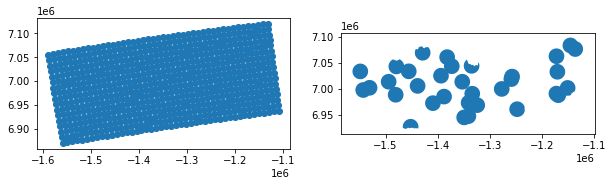

In [9]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)

merge_reprojetado.plot(ax=ax[0])
buffer_recortado.plot(ax=ax[1])

#### Calculando as médias das séries dentro do buffer

Neste ponto, são recortados todos os pontos de grade do MERGE que caem dentro do limite estipulado pelo buffer em cada posto.

O buffer é relativo à representatividade da chuva daquele posto. Para possibilitar o preenchimento de falhas das séries de chuva observada pelo posto pluviométrico com os dados de satélite, é realizada a média das séries de cada ponto de grade do satélite que cai dentro do buffer do posto.

A seguir, mostramos um exemplo das regiões de cada buffer e os pontos de grade do MERGE nele incluídos.

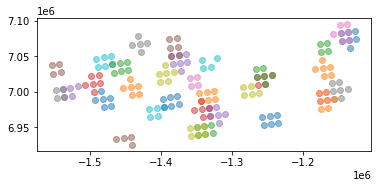

In [10]:
intersecoes = list()
fig, ax = plt.subplots()
for ix in buffer_recortado.index:
    buffer_posto = buffer_recortado.loc[ix]
    codigo_posto = buffer_posto.name
    coords_posto = buffer_posto.coordenadas

    gpd_buffer = gpd.GeoDataFrame(buffer_posto).T
    gpd_buffer = gpd_buffer.set_crs(epsg=config.epsg)
    gpd_buffer.rename({"coordenadas": "coords_posto"}, axis=1, inplace=True)
    
    merge_dentro_do_buffer = contornos.obter_intersecao(contorno=merge_reprojetado, mascara=gpd_buffer)
    merge_dentro_do_buffer.plot(ax=ax, alpha=0.5)
    lista_pontos_grade = merge_dentro_do_buffer.geometry.tolist()    

    gdf_merge_dentro = contornos.criar_geodataframe(coordenadas=lista_pontos_grade)
    gdf_merge_dentro = gdf_merge_dentro.set_crs(epsg=config.epsg)
    gdf_merge_dentro_geografico = contornos.converter_epsg(gdf_merge_dentro, config.epsg_inicial)

    series_prec = list()
    for ix in gdf_merge_dentro_geografico.index:
        coordenada = gdf_merge_dentro_geografico.loc[ix, 'geometry']
        latitude = coordenada.y
        longitude = coordenada.x

        ds_ponto = ds.sel(latitude=latitude, longitude=longitude, method='nearest').prec
        ds_ponto = ds_ponto.drop(["latitude", "longitude"])
        df_ponto = ds_ponto.to_dataframe()
        df_ponto.reset_index(inplace=True)
        df_ponto.rename({"valid_time": "data"}, axis=1, inplace=True)
        df_ponto.set_index("data", inplace=True)
        df_ponto.index = pd.to_datetime(df_ponto.index).strftime("%Y-%m-%d")

        series_prec.append(df_ponto)
    
    df_prec = pd.concat(series_prec, axis=1)
    media_prec = df_prec.mean(axis=1)
    

    intersecao = modelos.IntersecaoSatelitePosto(
        coords_posto=gpd_buffer.coords_posto[0],
        codigo_posto=codigo_posto,    
        pontos_grade=lista_pontos_grade,
        serie_satelite=media_prec
    )

    intersecoes.append(intersecao)

### Preenchimento das séries dos postos com satélite

#### Visualização das séries de diferença entre satélite e postos pluviométricos

Neste ponto, geramos uma visualização das séries de chuva obtidas pela média regional do MERGE no buffer de cada posto e a série de chuva do próprio posto pluviométrico. Estatísticas básicas, como a média e o desvio padrão da série de diferenças, são demonstradas nos gráficos de cada posto. 

Observado que as diferenças são relativamente pequenas quando considerando estas estatísticas, percebe-se empiricamente que o preenchimento das falhas com os dados de satélite não representa um desvio díspare da realidade.

/tmp/ipykernel_2112043/2900126894.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=2, figsize=(24, 8))


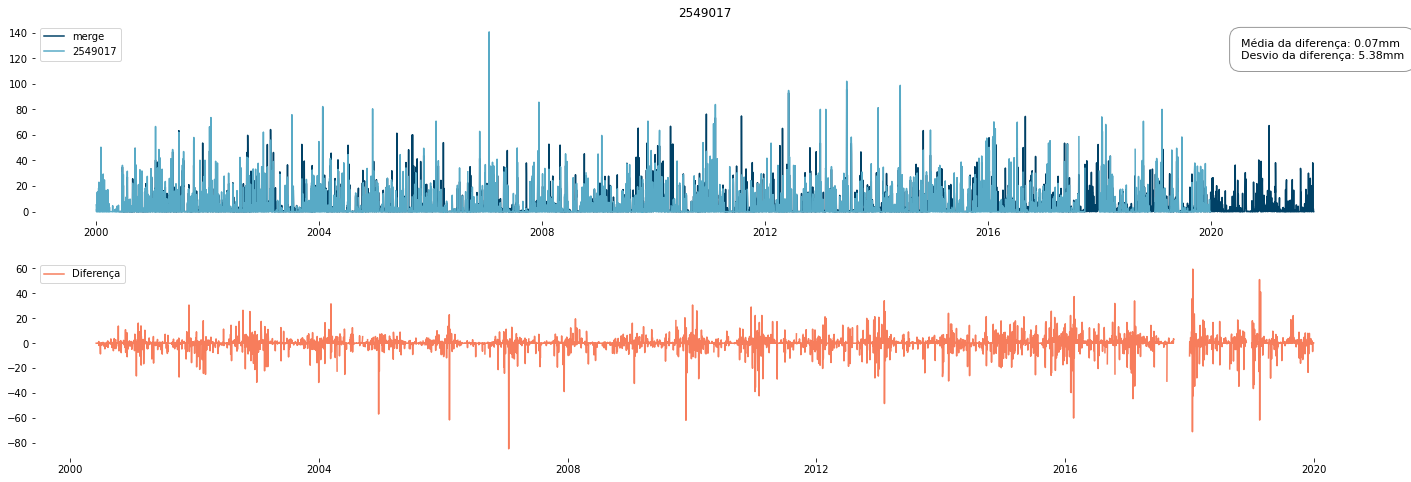

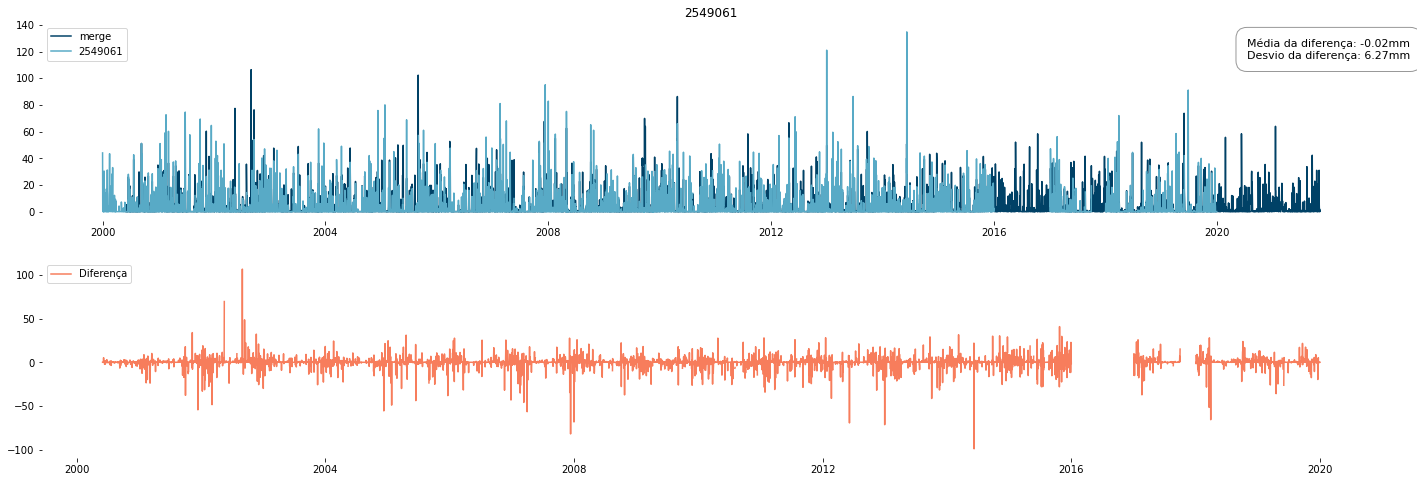

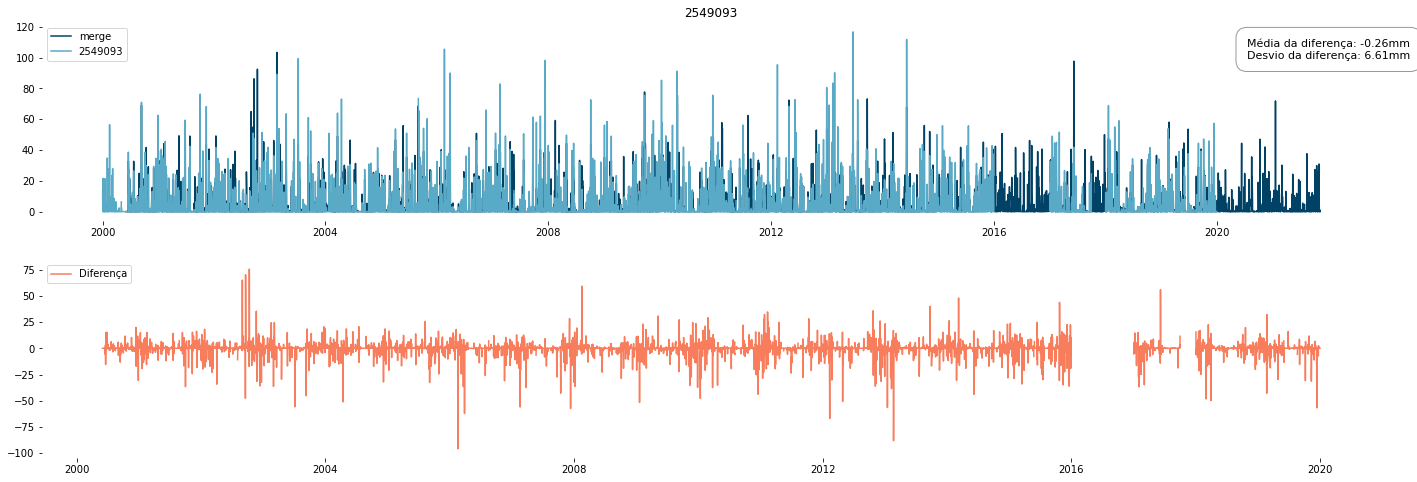

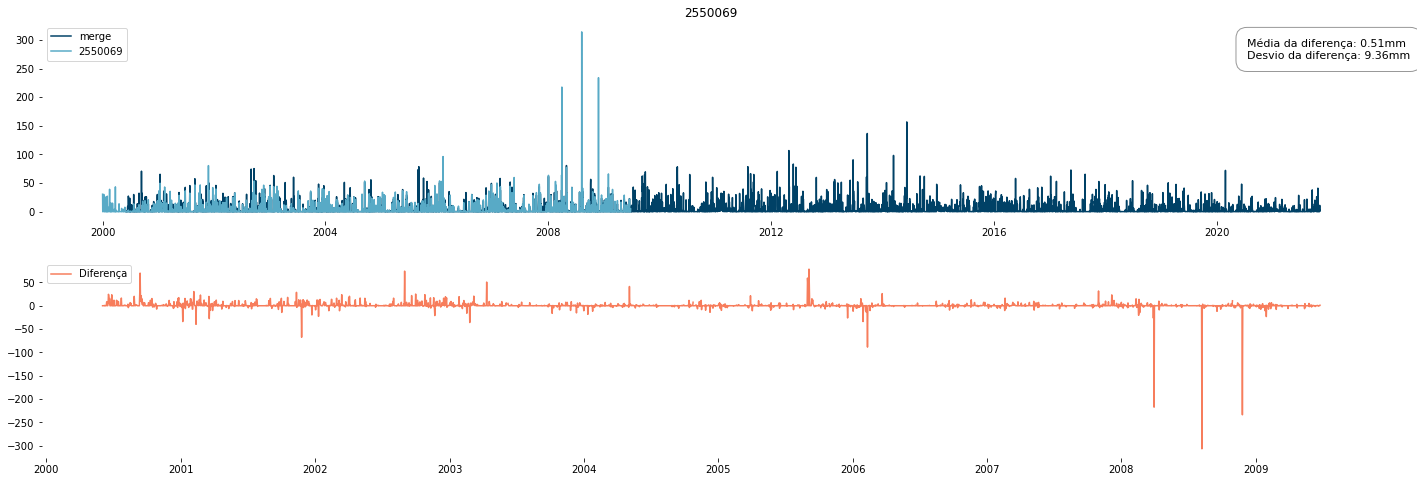

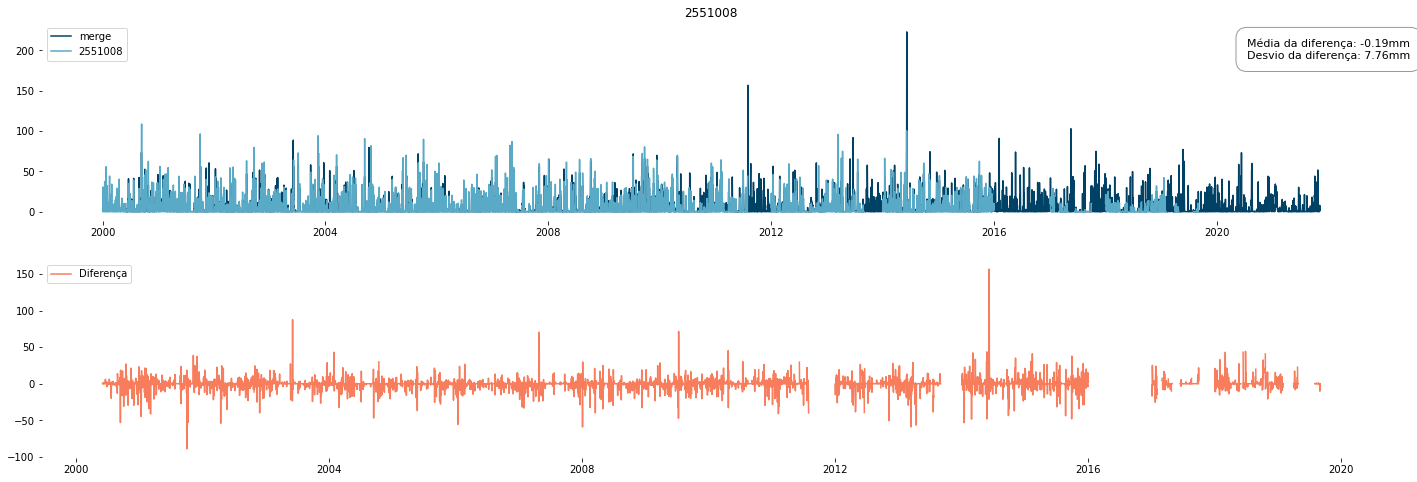

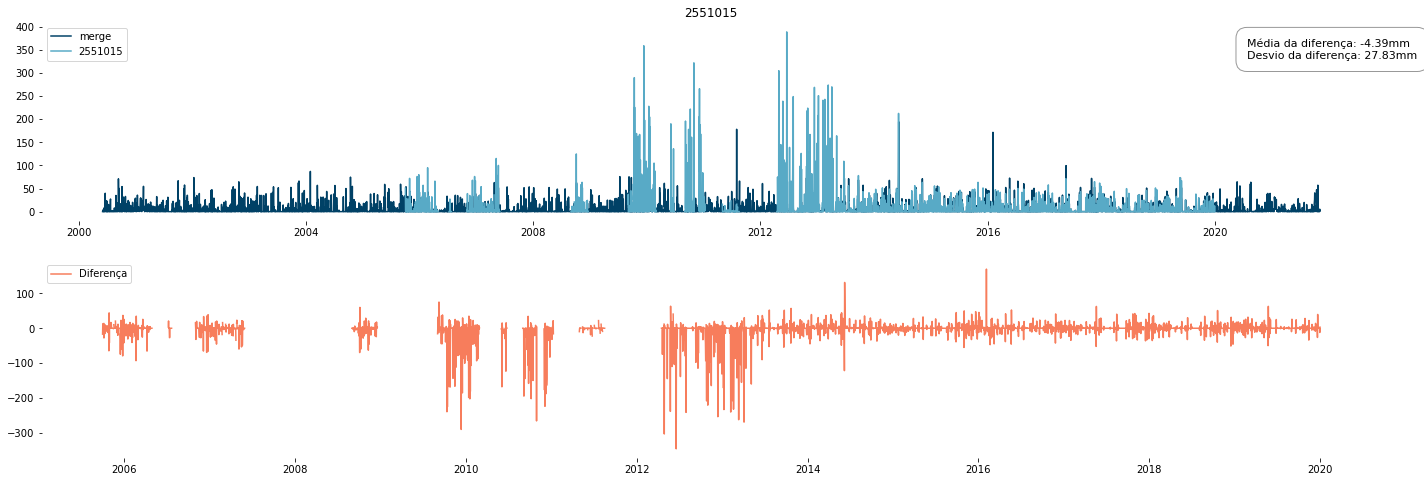

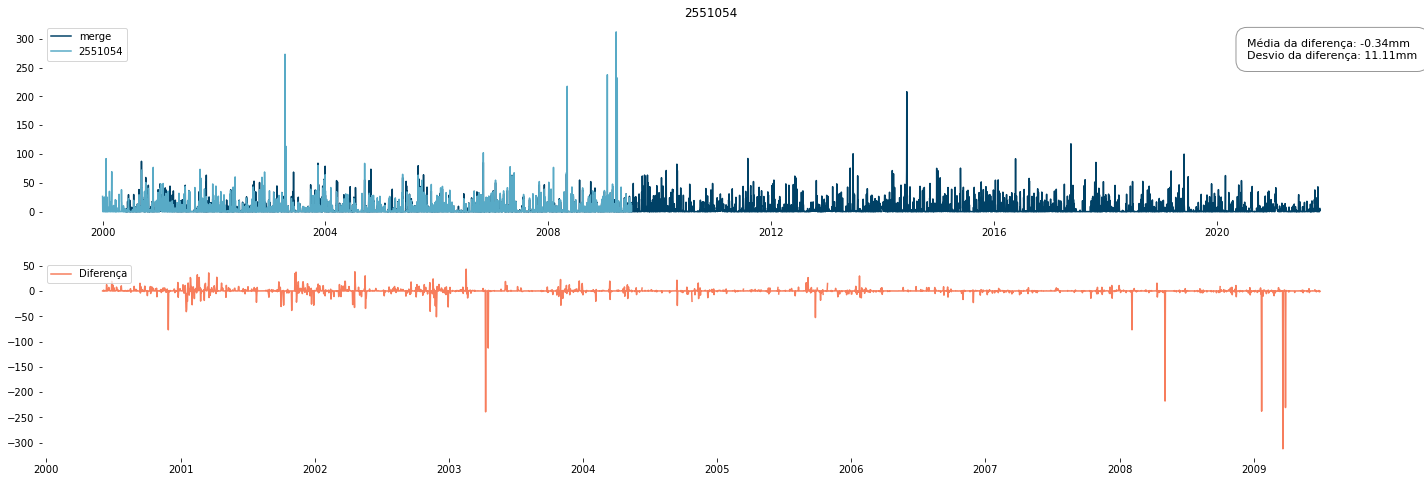

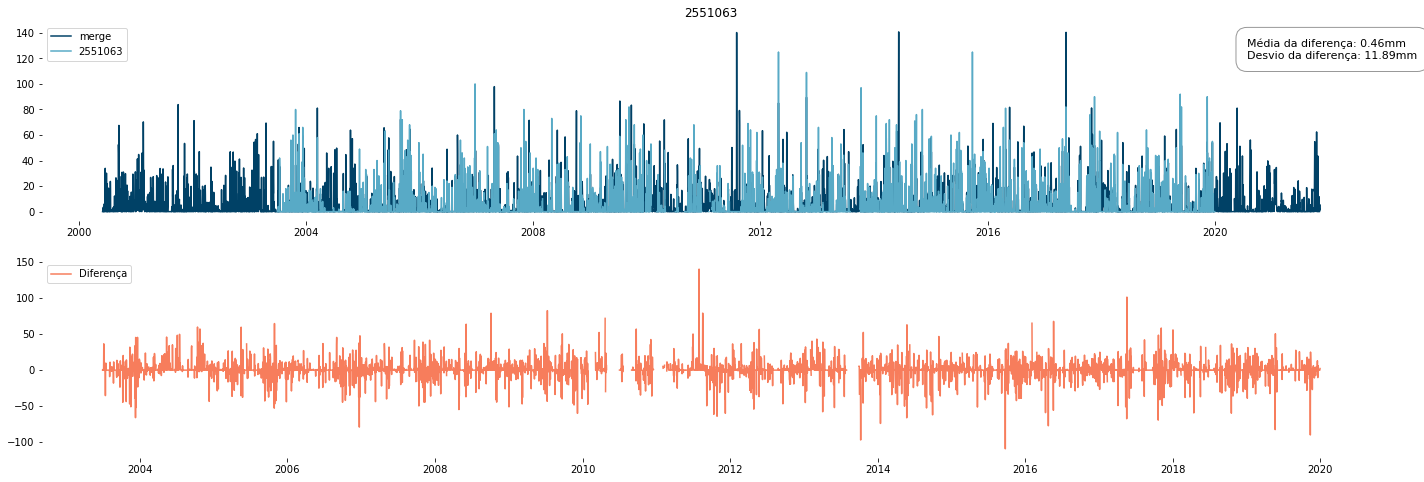

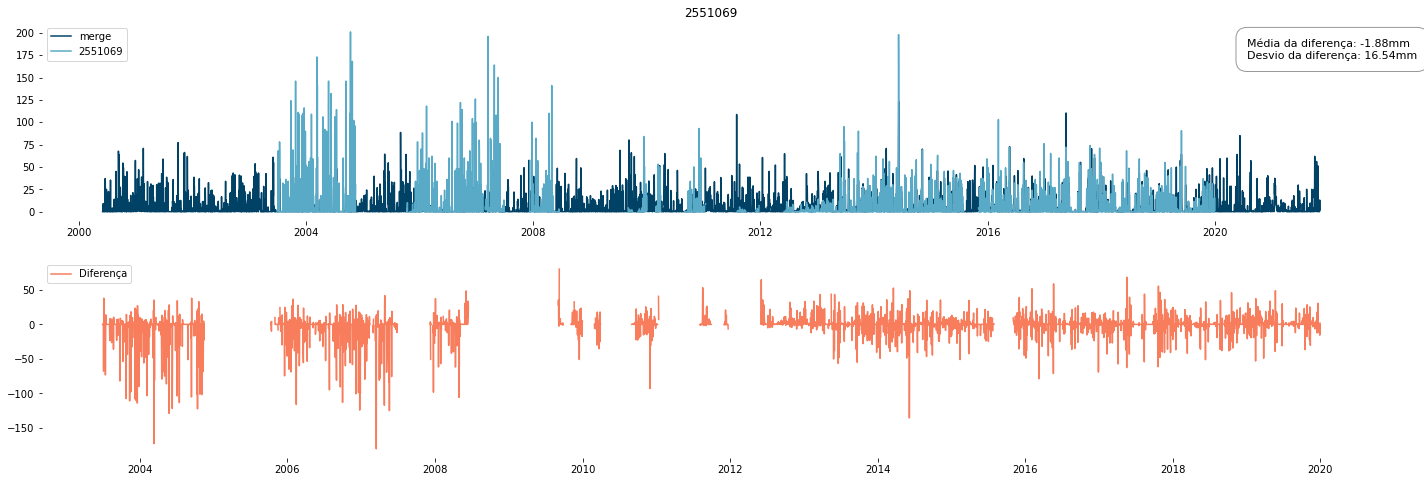

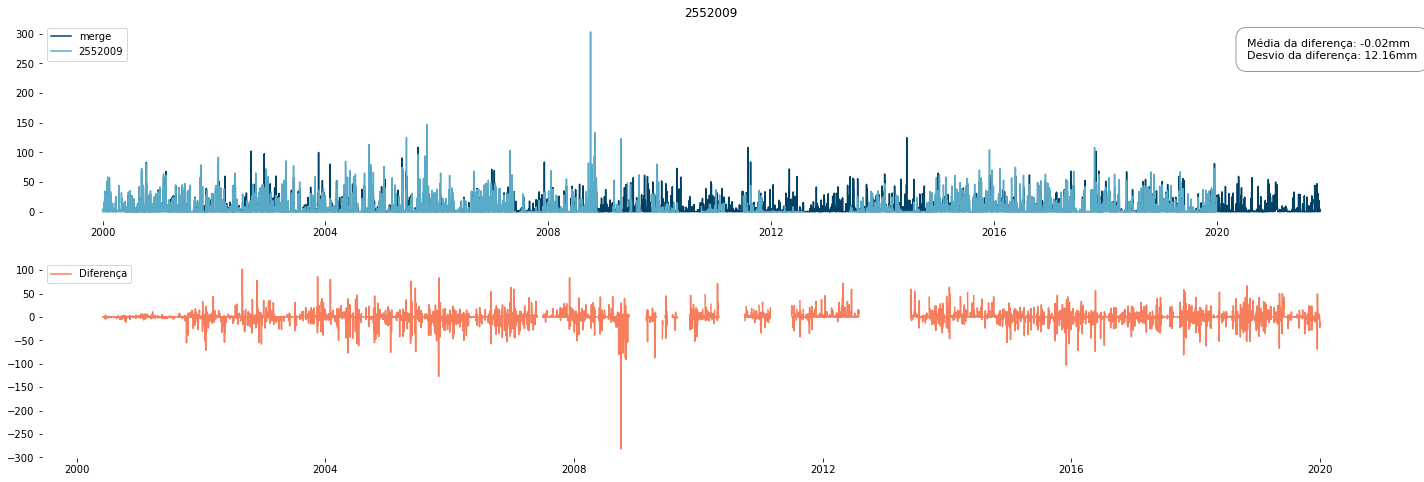

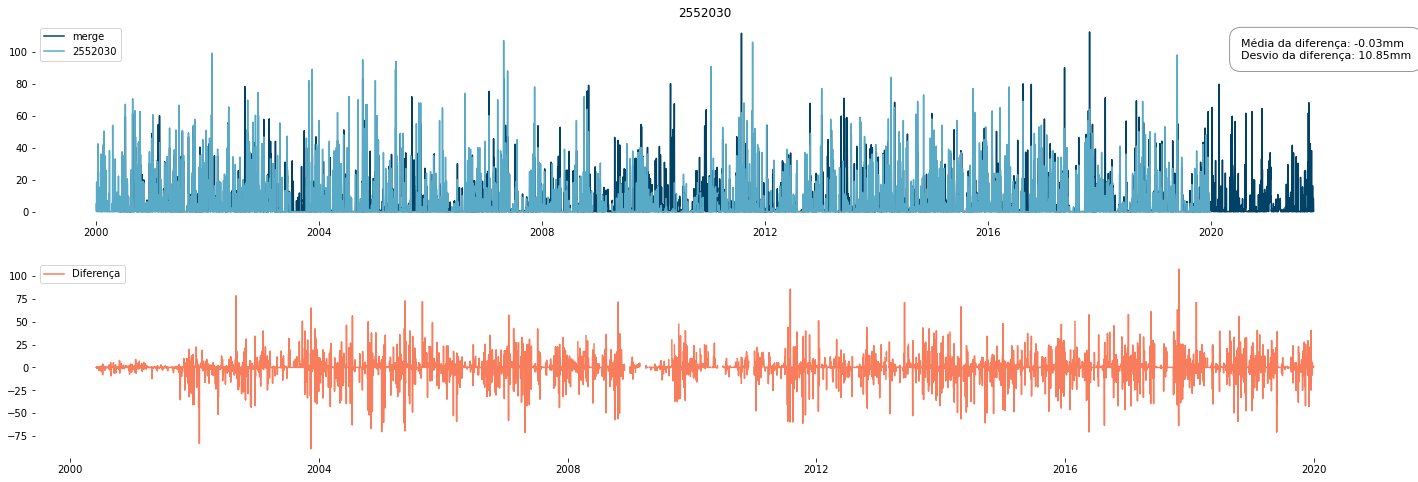

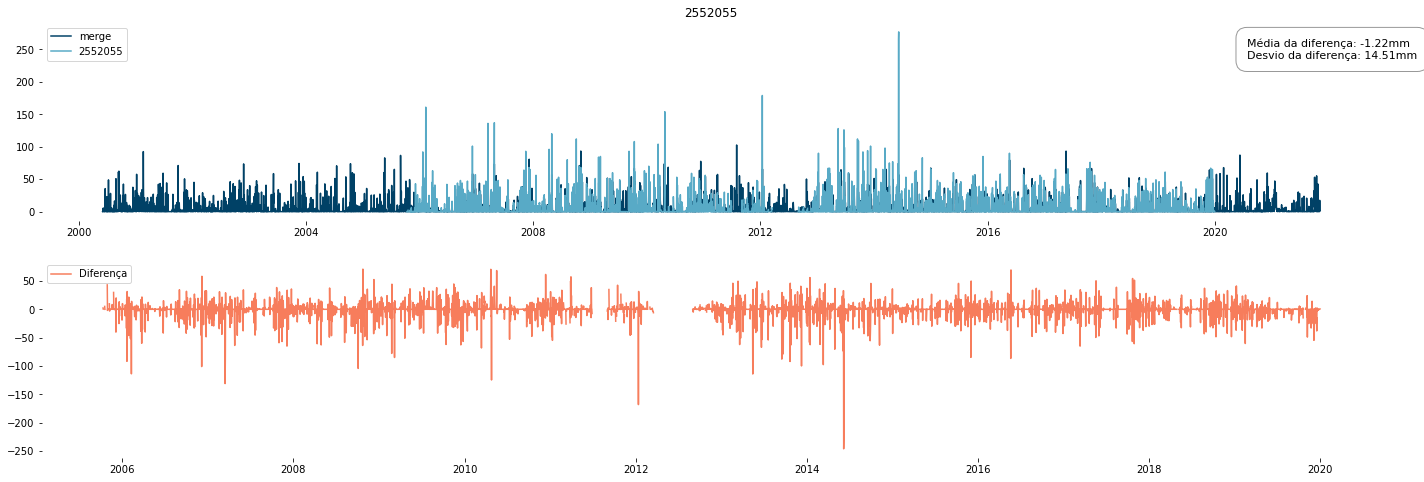

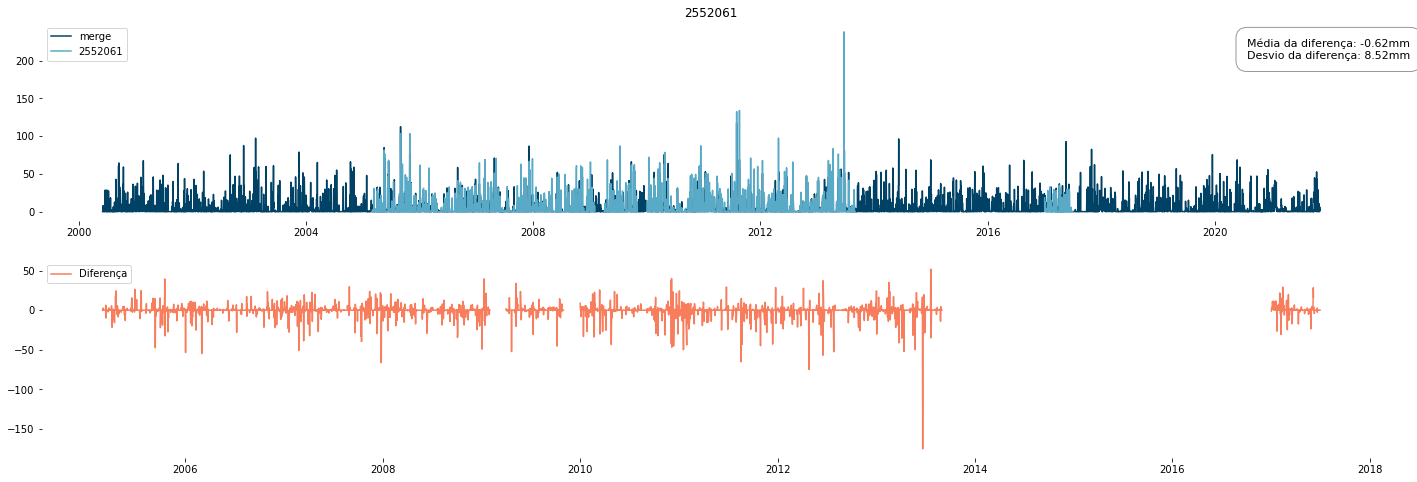

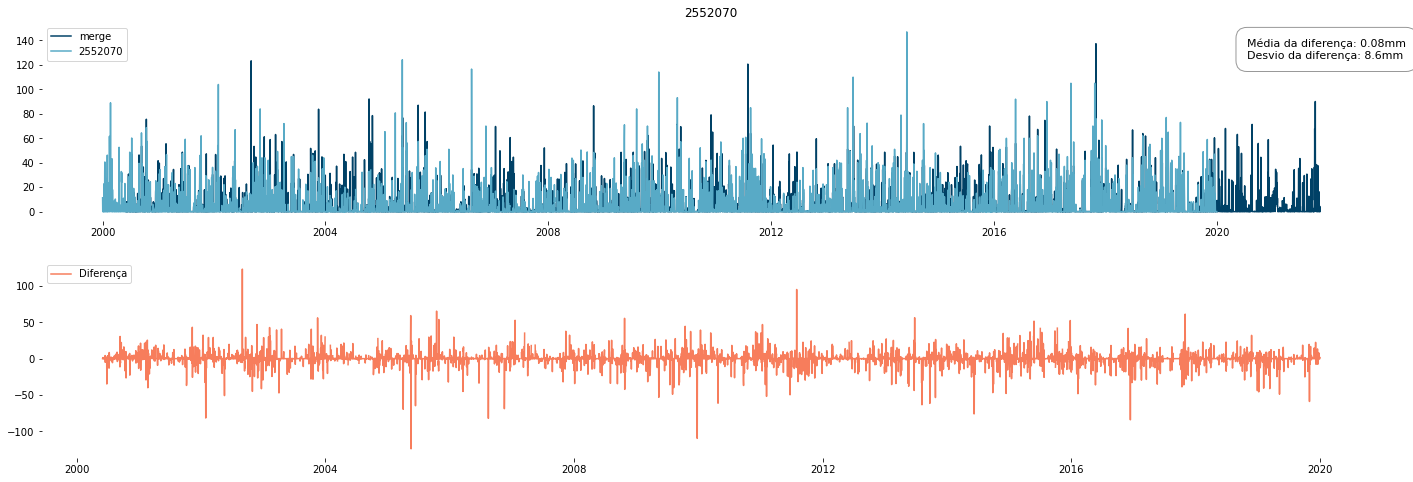

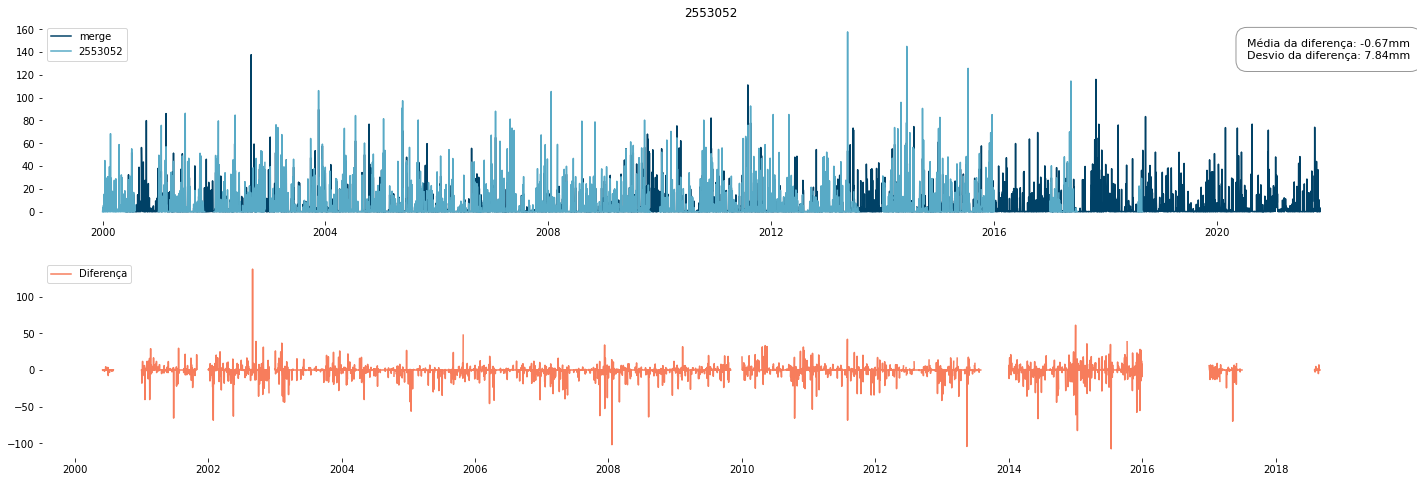

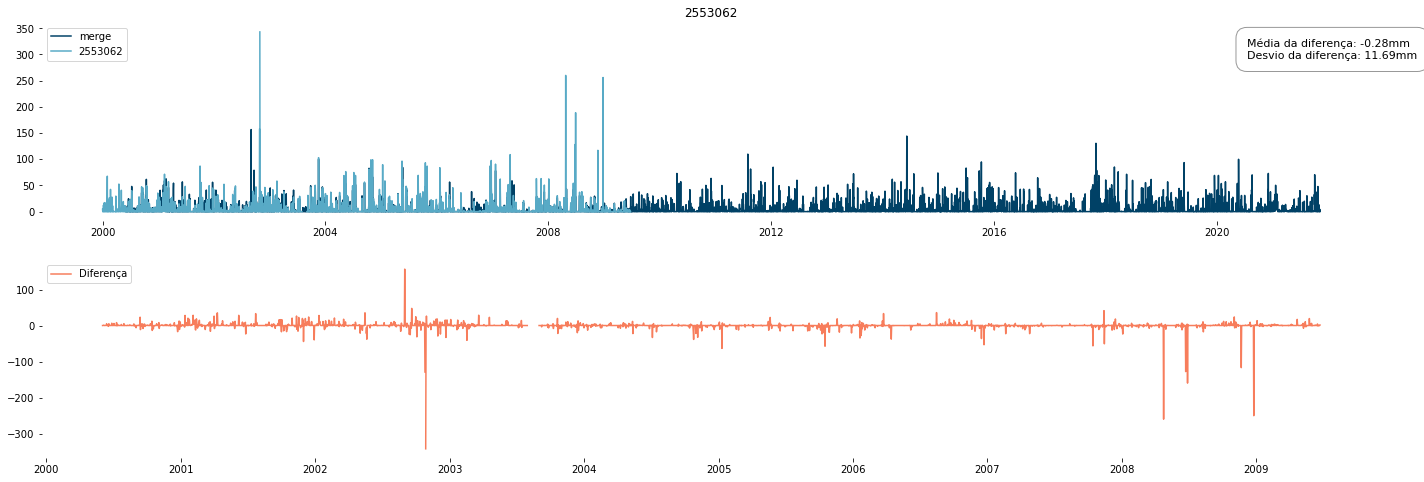

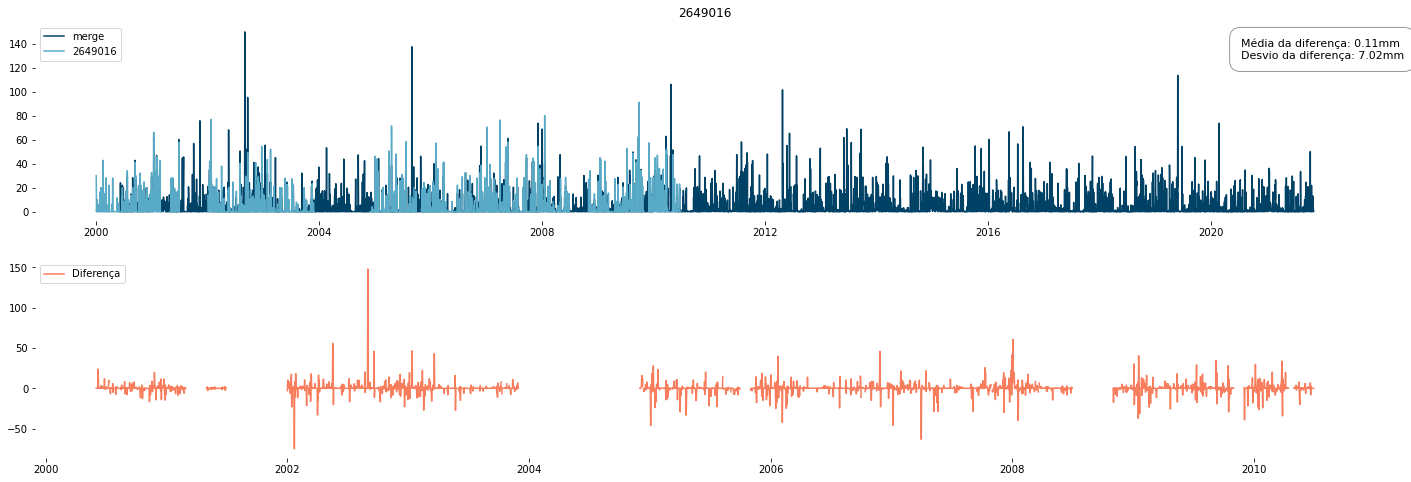

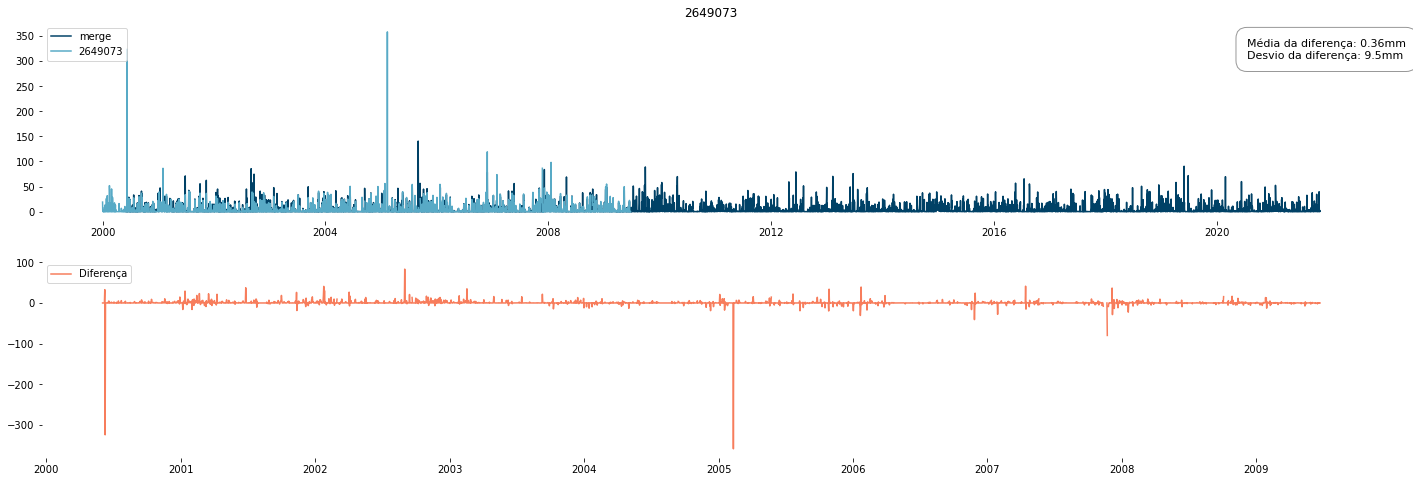

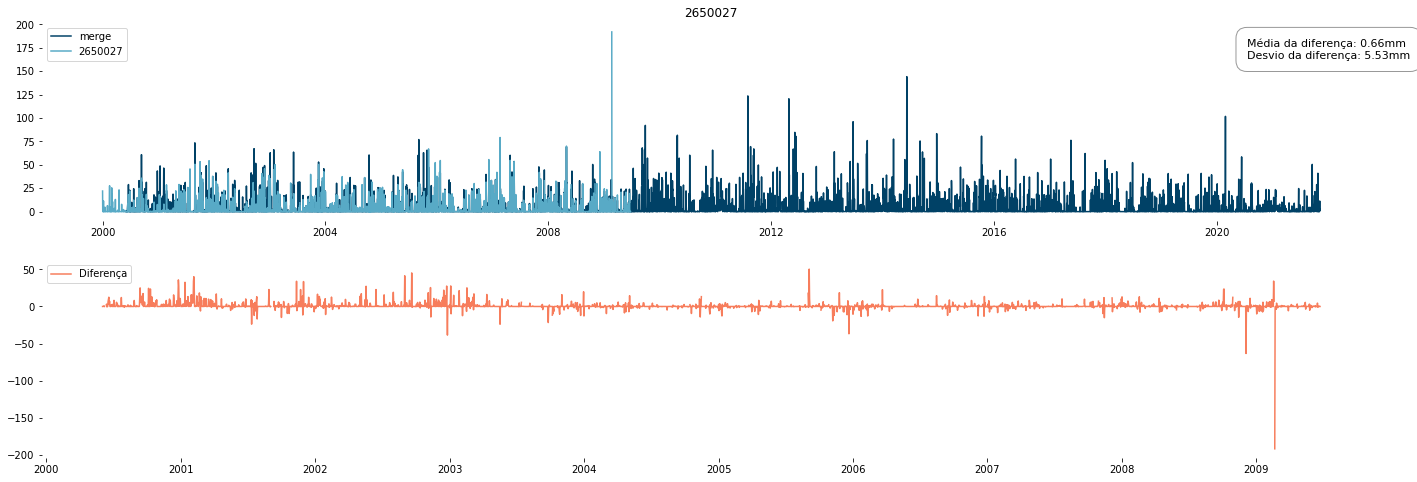

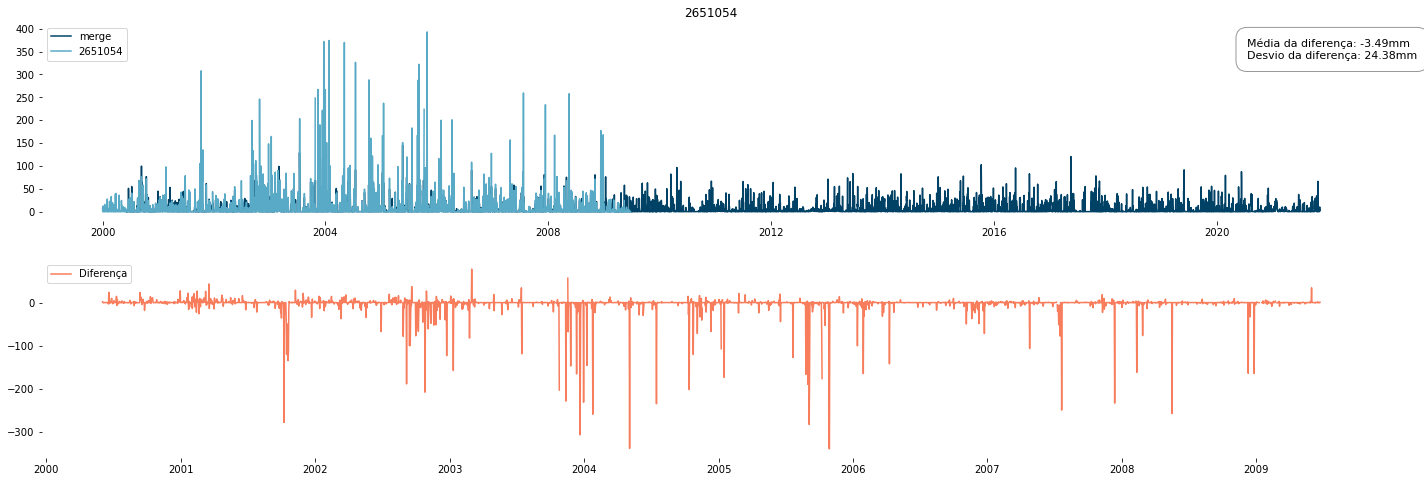

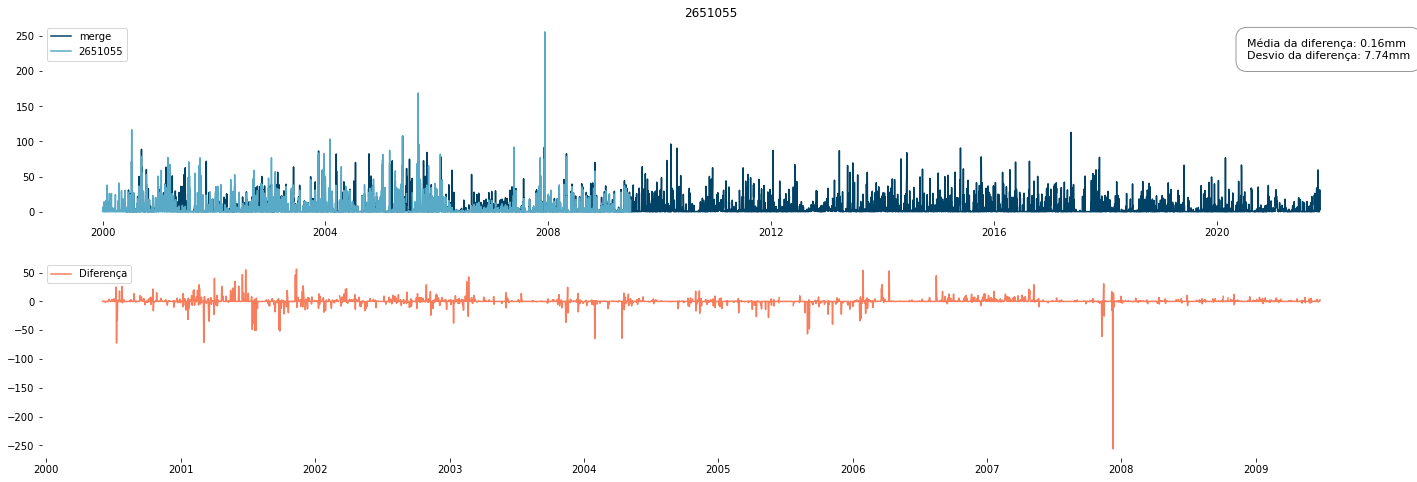

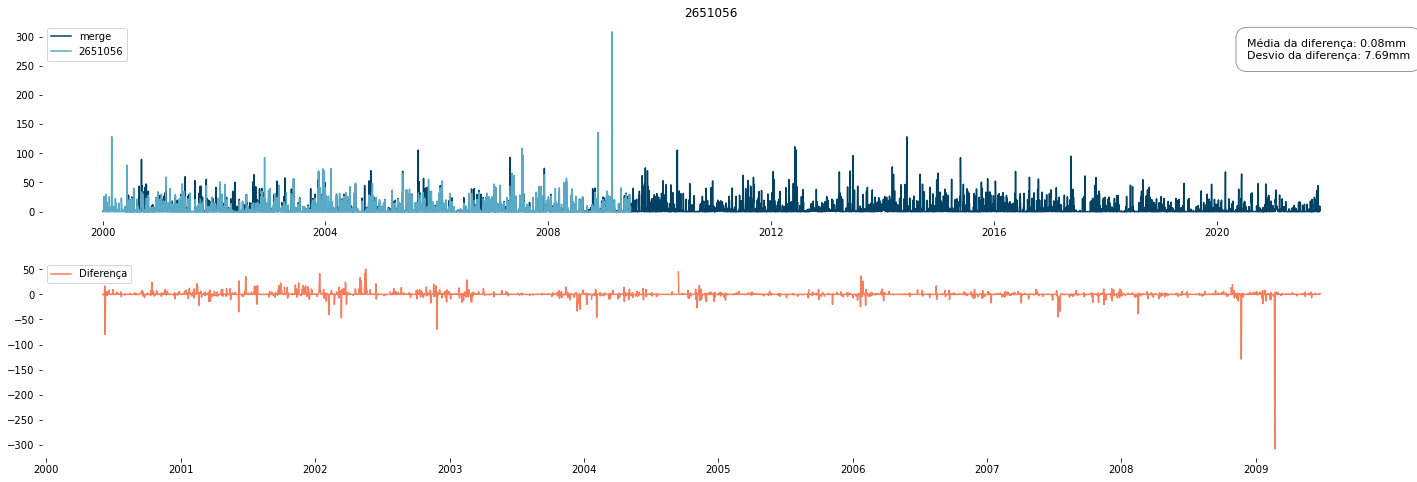

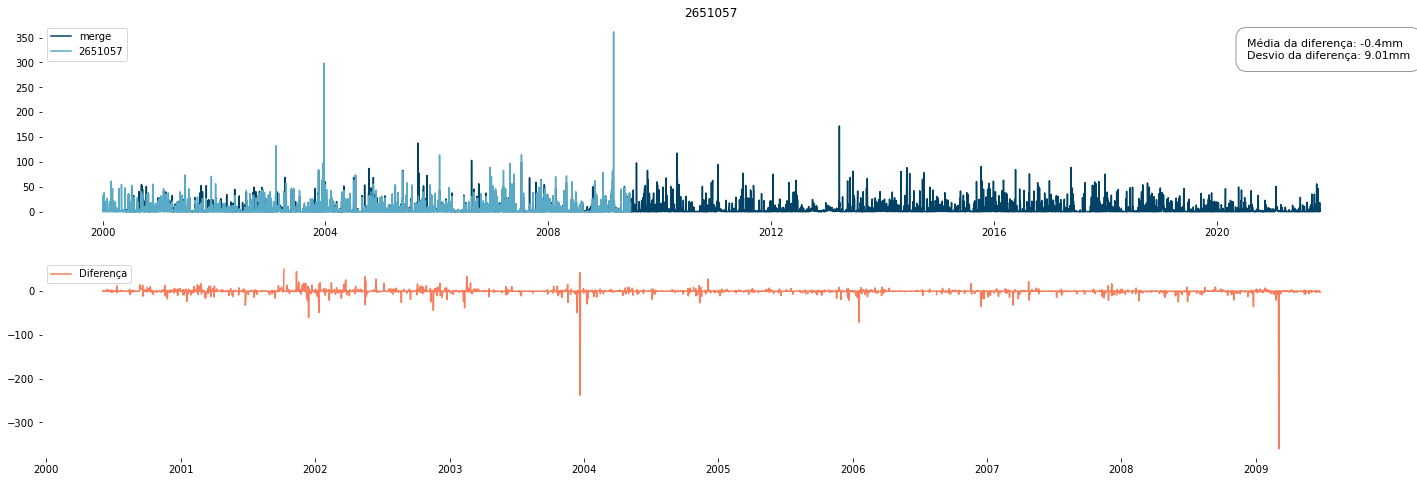

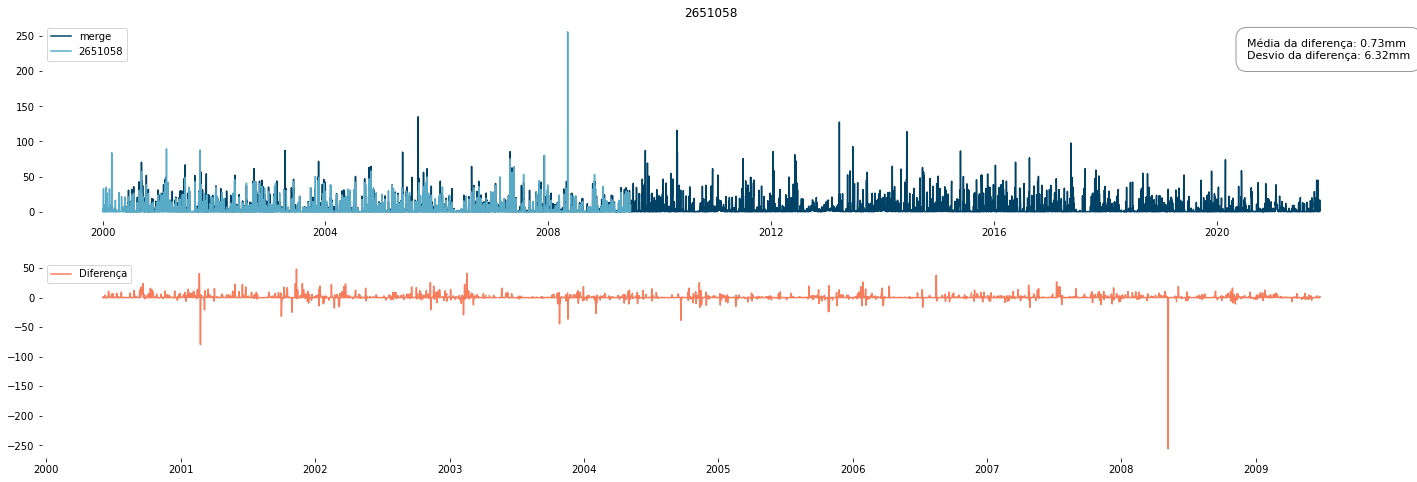

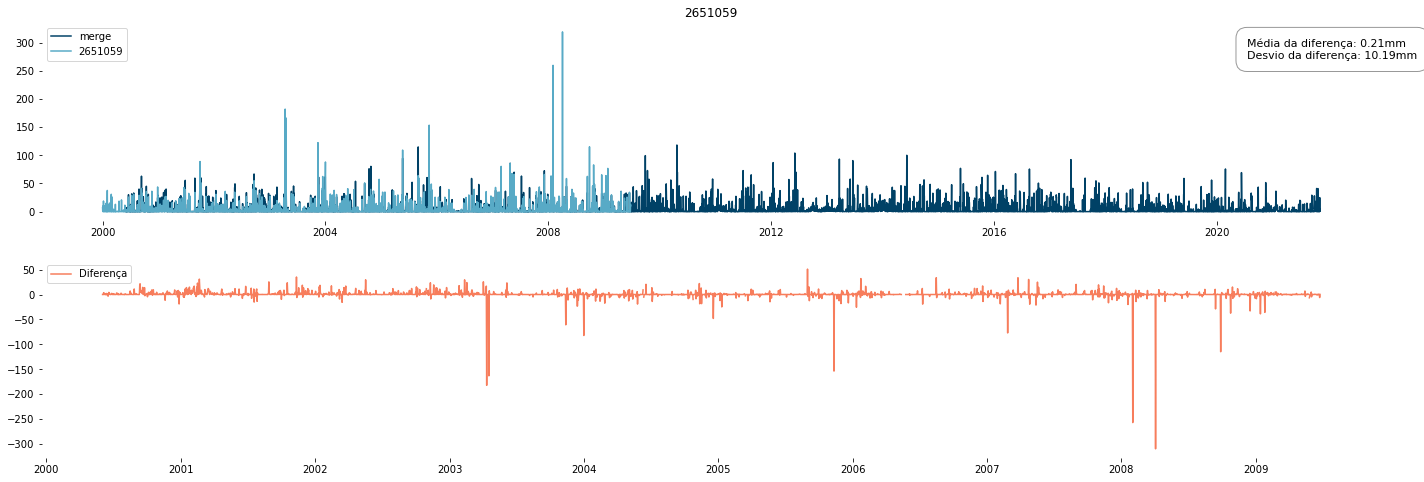

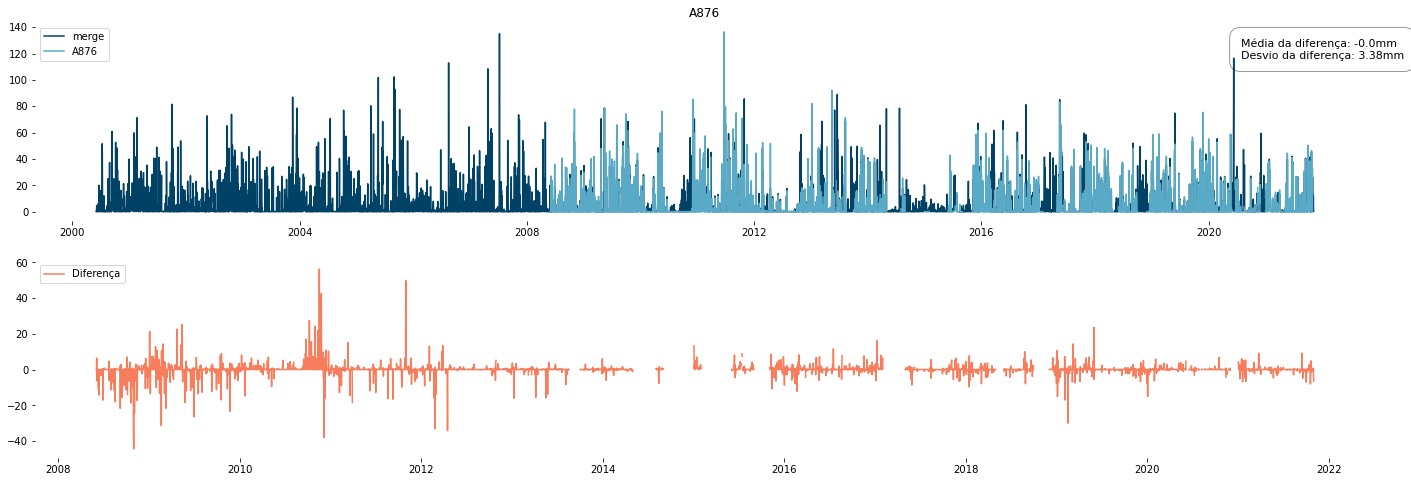

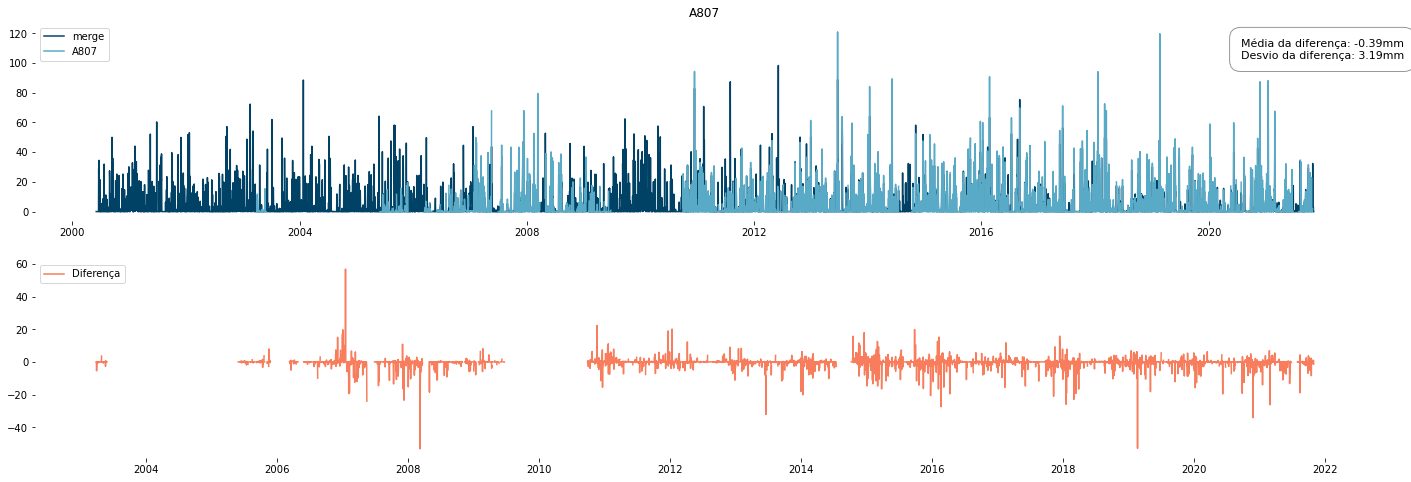

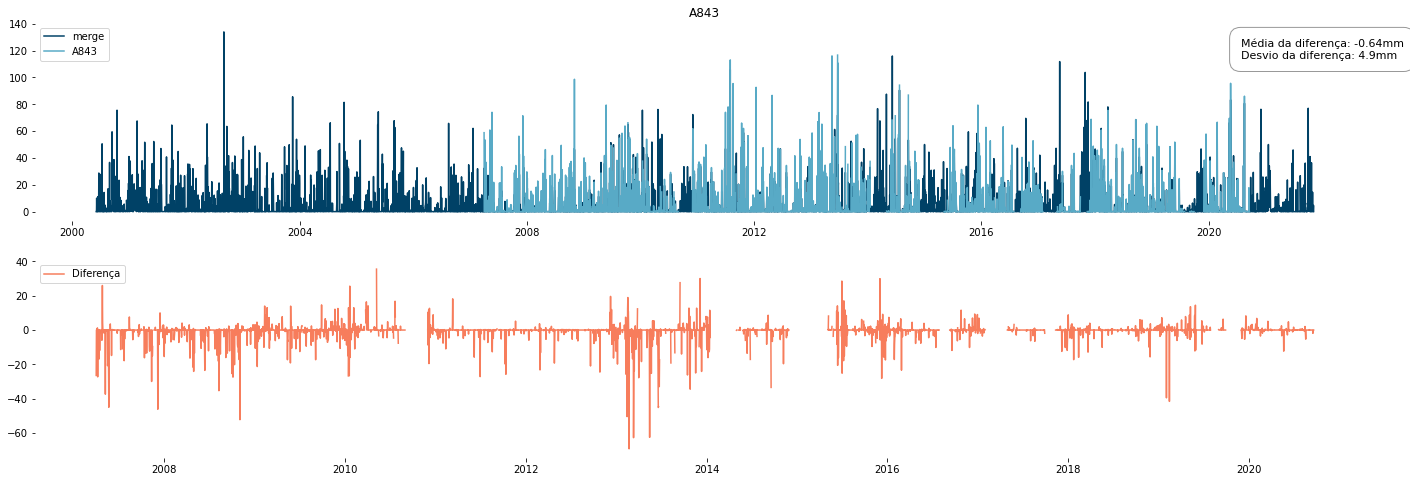

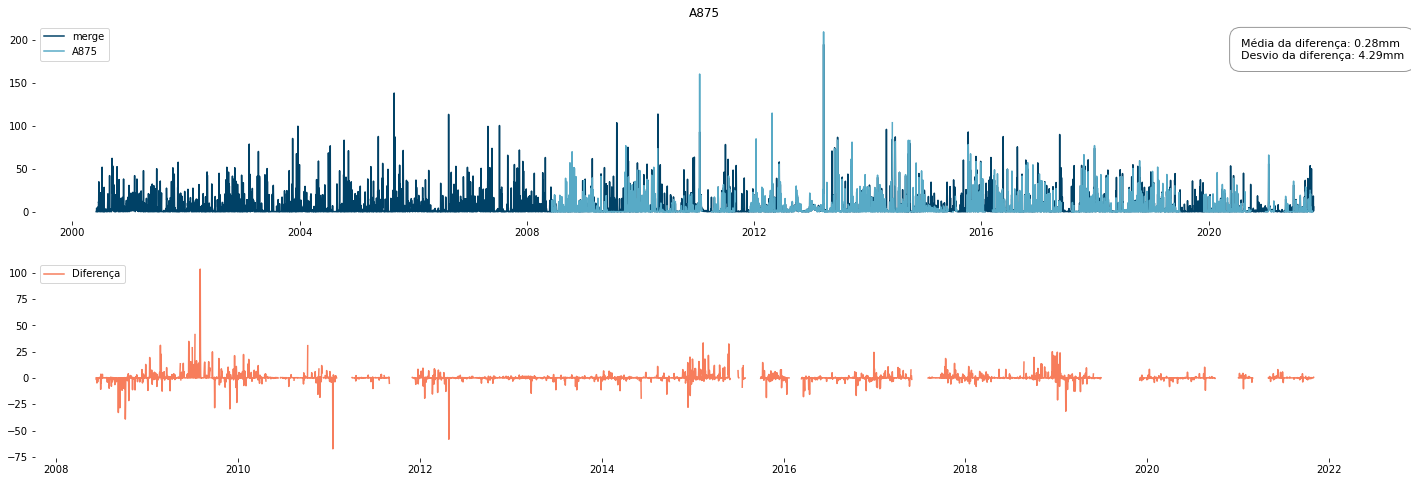

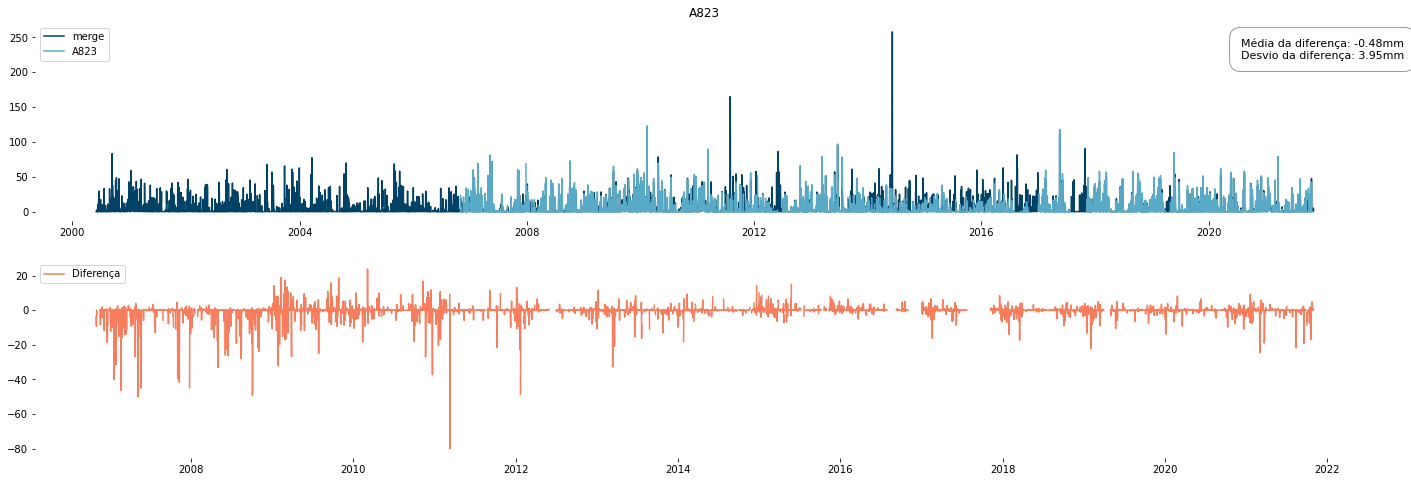

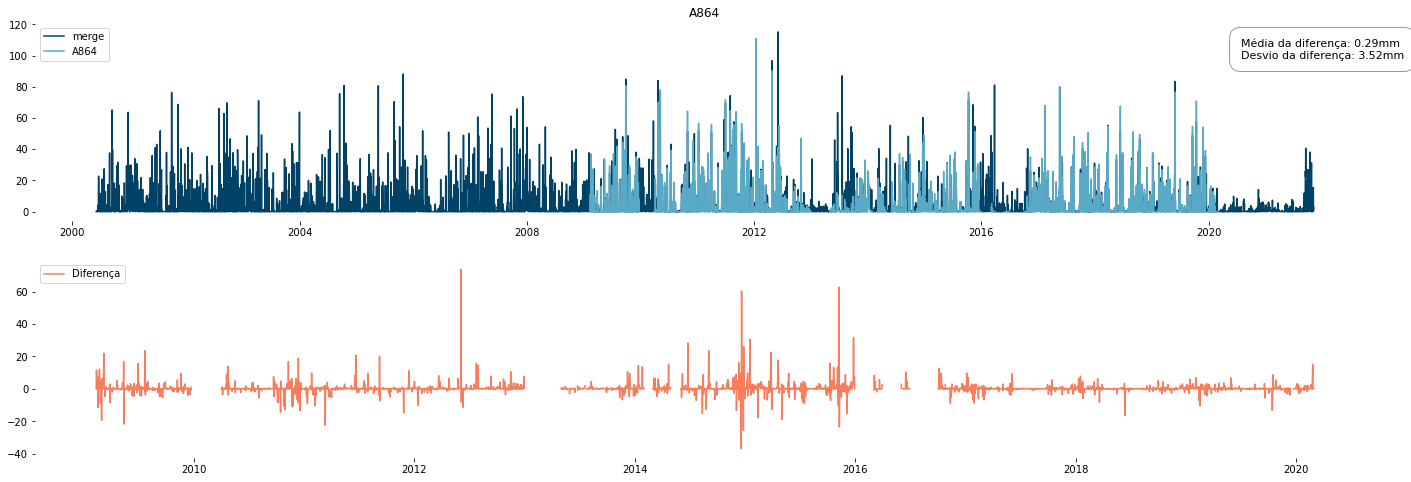

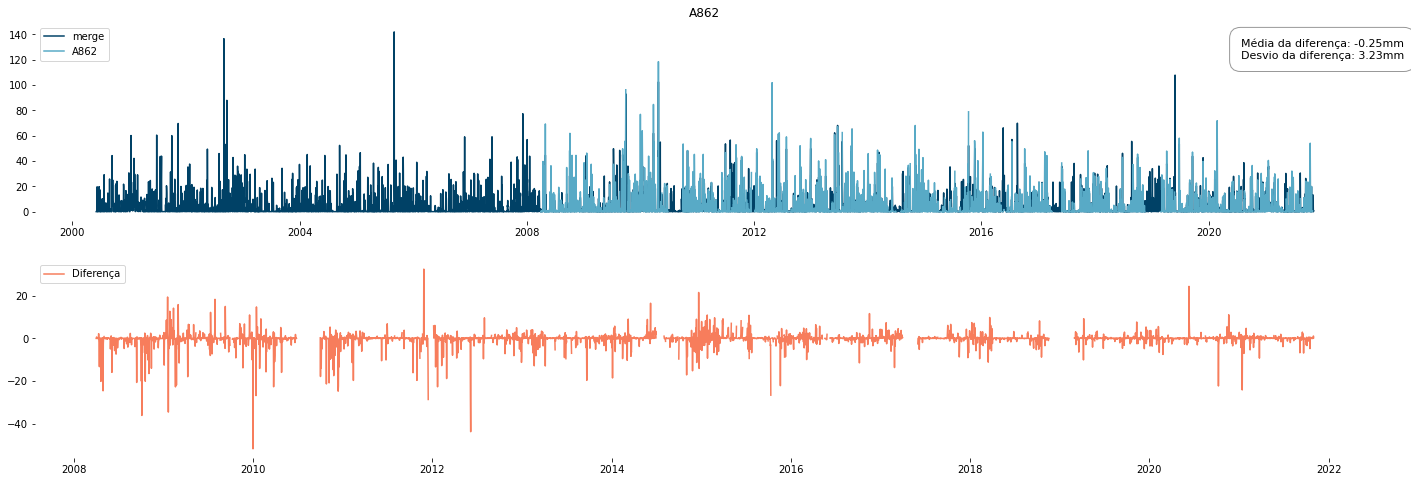

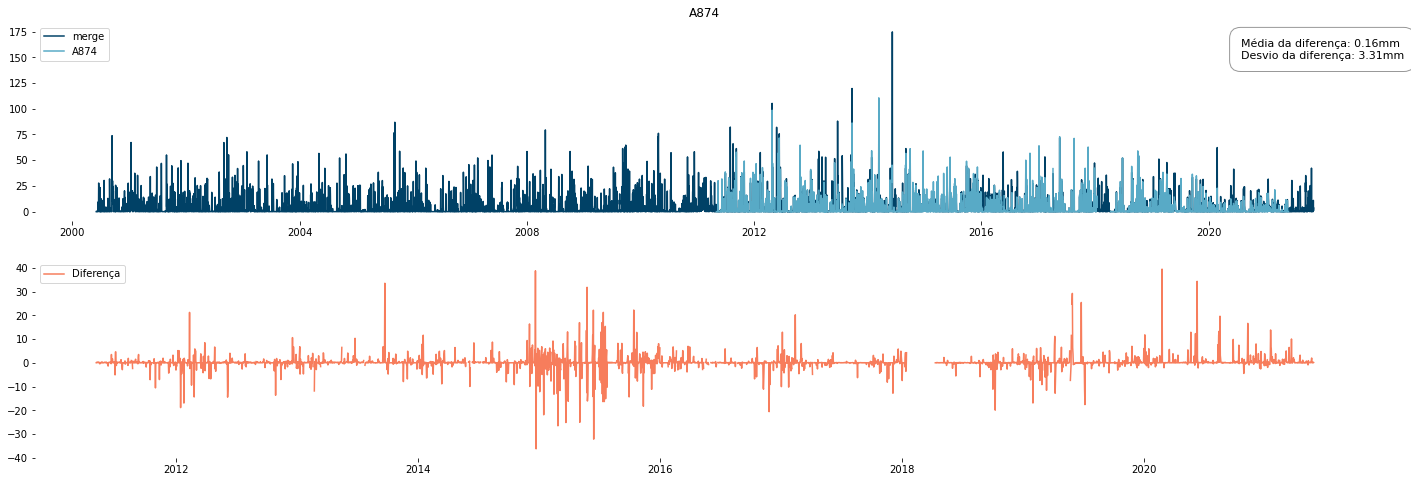

In [11]:
bbox = dict(boxstyle="round", pad=1, fill=None, alpha=0.4, ec="k")

for dado in intersecoes:
    codigo_posto = dado.codigo_posto
    serie_posto = series_postos[codigo_posto]
    serie_satelite = dado.serie_satelite
    serie_satelite.name = 'merge'
    df_comparacao = pd.concat([serie_posto, serie_satelite], axis=1)
    df_comparacao = df_comparacao.assign(diferenca = df_comparacao['merge'] - df_comparacao[codigo_posto])
    df_comparacao.to_csv(config.dir_merge_posto.joinpath(f"{codigo_posto}.csv"))

    estatisticas = df_comparacao.describe()
    media_dif = estatisticas.loc['mean', 'diferenca']
    desv_dif = estatisticas.loc['std', 'diferenca']
    df_comparacao.index = pd.to_datetime(df_comparacao.index)

    fig, ax = plt.subplots(nrows=2, figsize=(24, 8))

    ax[0].plot(df_comparacao['merge'], color="#004166", label="merge",)
    ax[0].plot(df_comparacao[codigo_posto], color="#58AAC6", label=f"{codigo_posto}")

    ax[1].plot(df_comparacao['diferenca'], color="#f77d5c", label="Diferença")

    ax[0].annotate(f"Média da diferença: {round(media_dif, 2)}mm\nDesvio da diferença: {round(desv_dif, 2)}mm", xy=(0.9, 0.82), xycoords='axes fraction', bbox=bbox, fontsize=11)
    ax[0].set_title(f"{codigo_posto}")
    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")

    for key, spine in ax[0].spines.items():
        spine.set_visible(False)
    
    for key, spine in ax[1].spines.items():
        spine.set_visible(False)

#### Preenchimento das falhas

O preenchimento de falhas irá considerar todos os arquivos csv disponíveis no diretório `merge-e-posto`, que contém as séries do próprio posto e a série calculada de satélite, esta última indexada pela coluna `merge`.

A seguir, são apresentadas visualizações destas séries após preenchimento. Todas as séries preenchidas são exportadas para o diretório `series-preenchidas`.

In [12]:
series_com_merge = list(config.dir_merge_posto.glob("*.csv"))

/tmp/ipykernel_2112043/328476946.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=2, figsize=(24, 8))


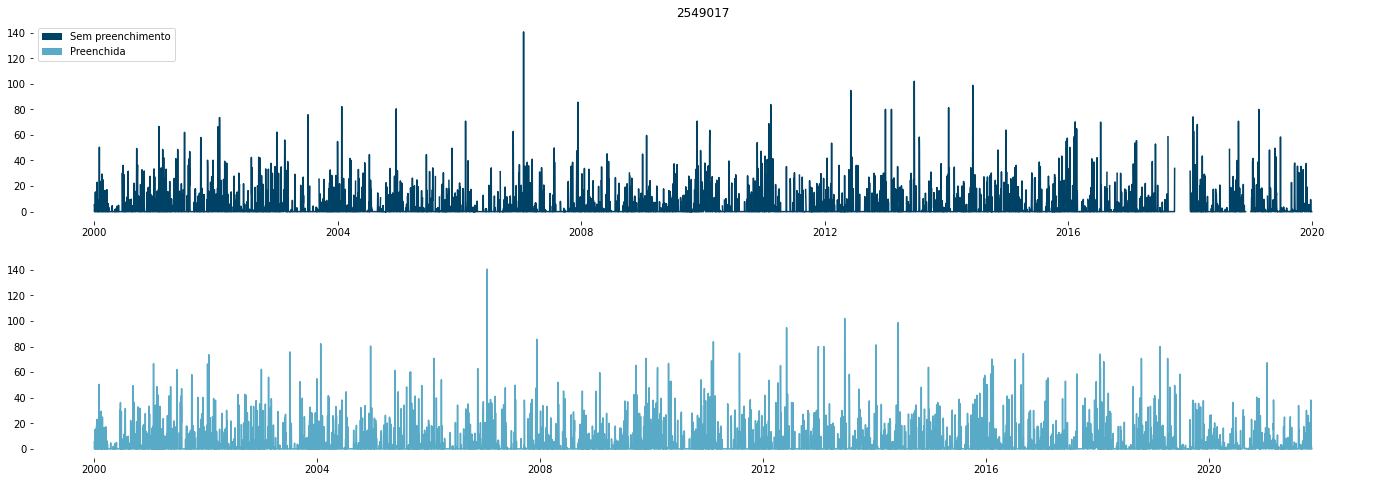

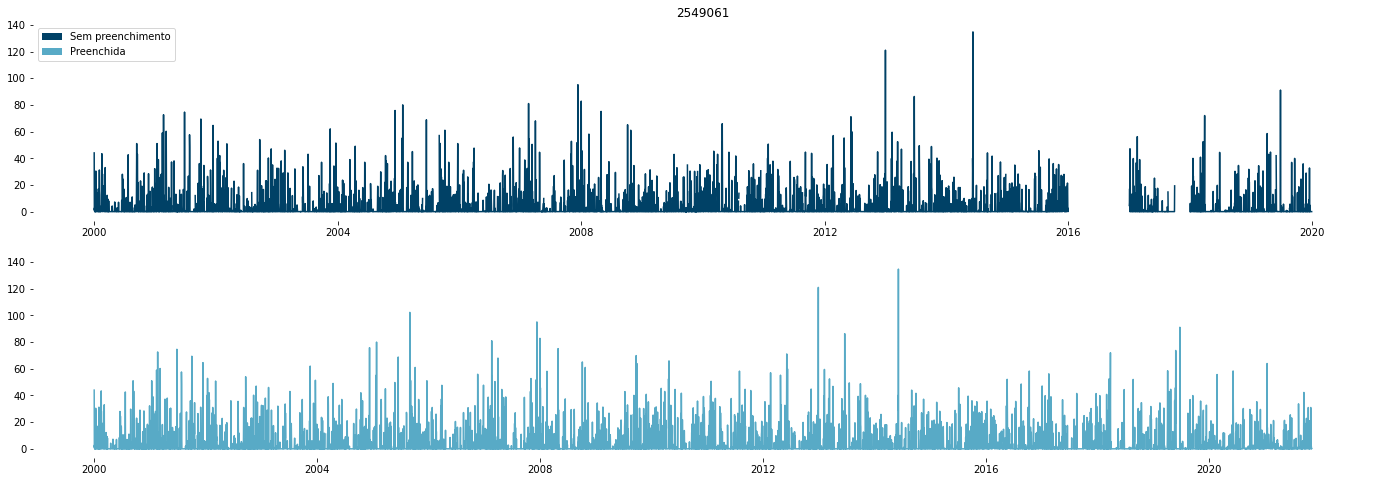

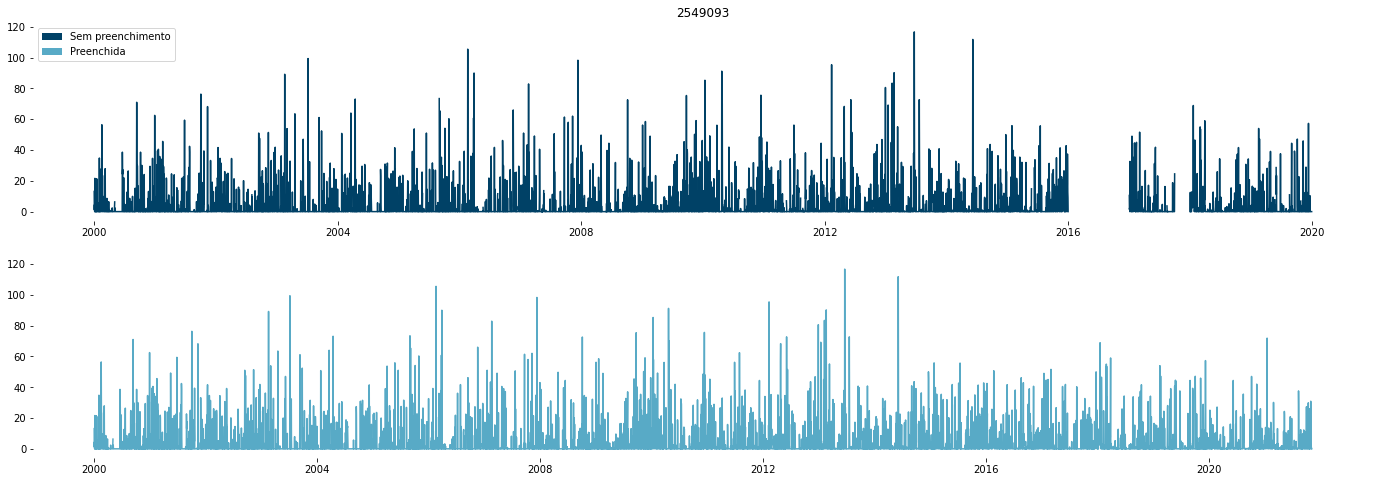

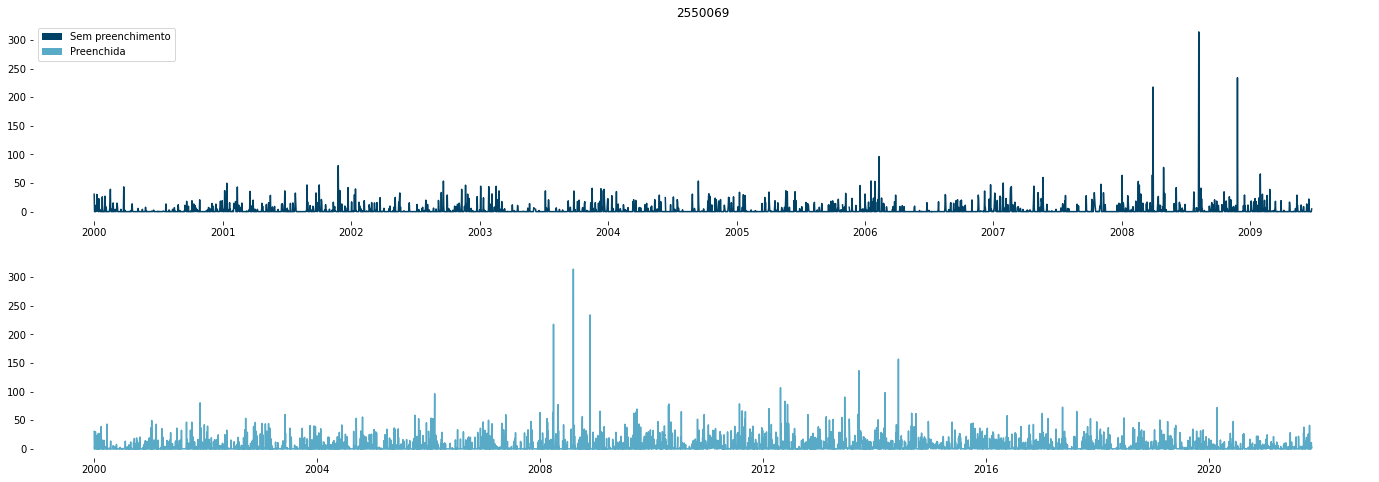

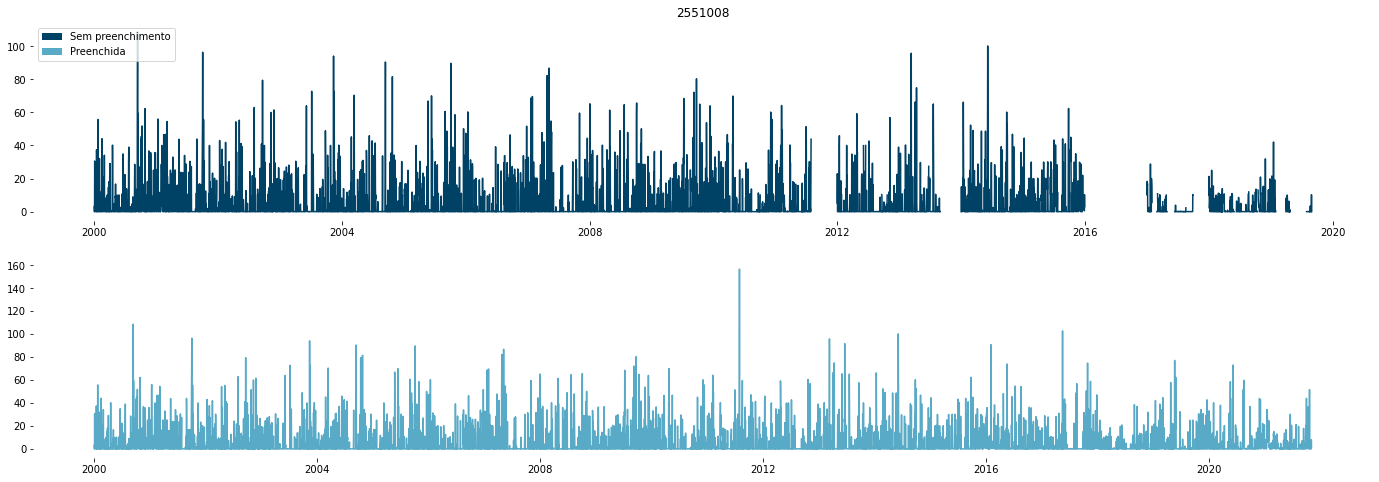

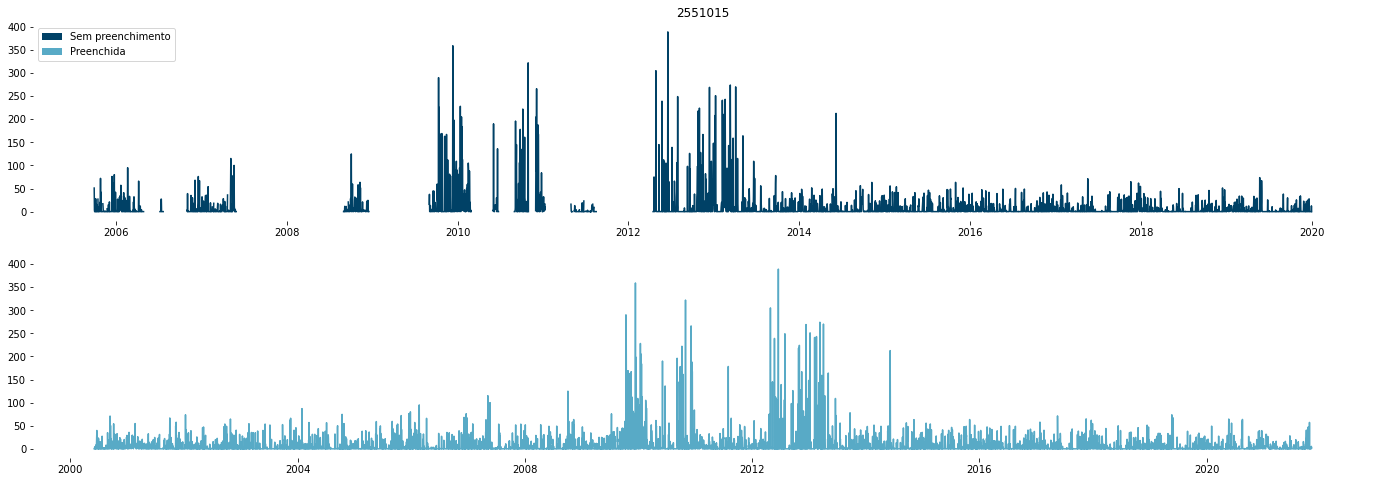

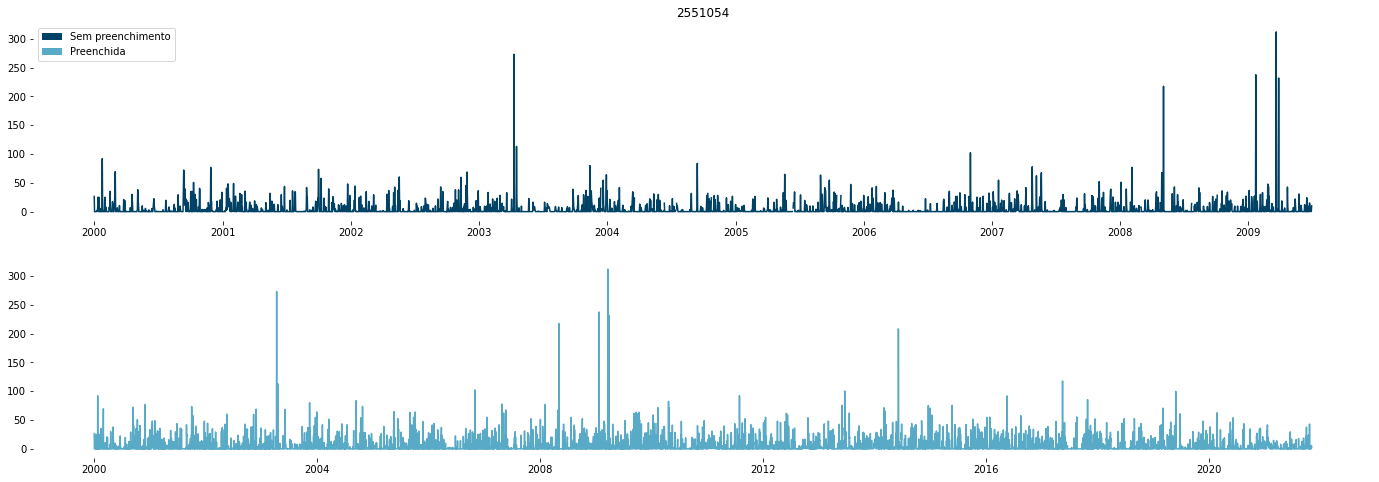

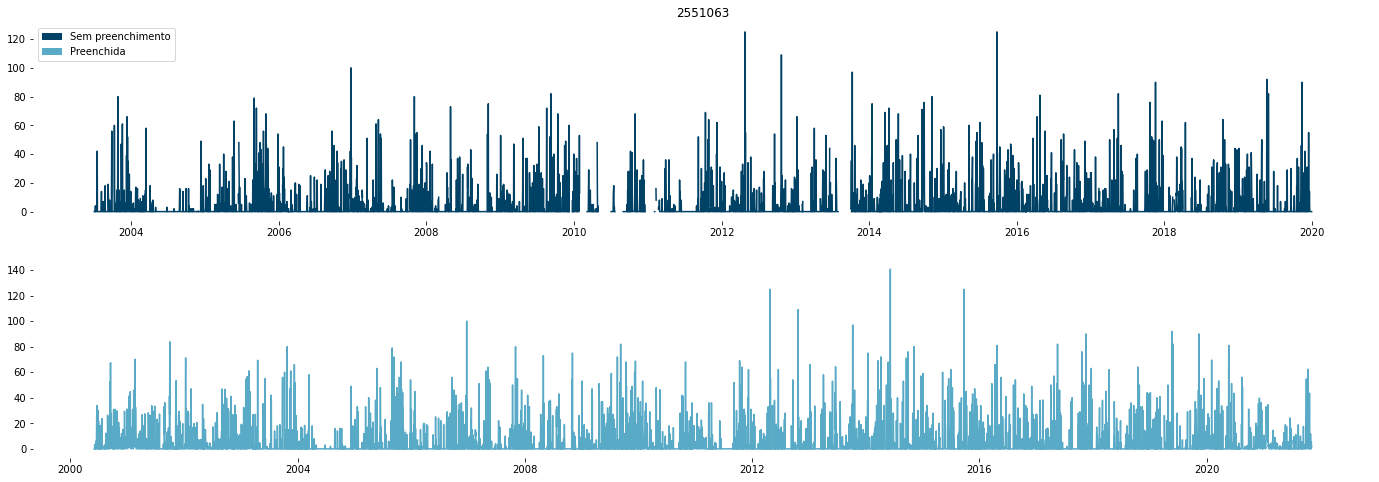

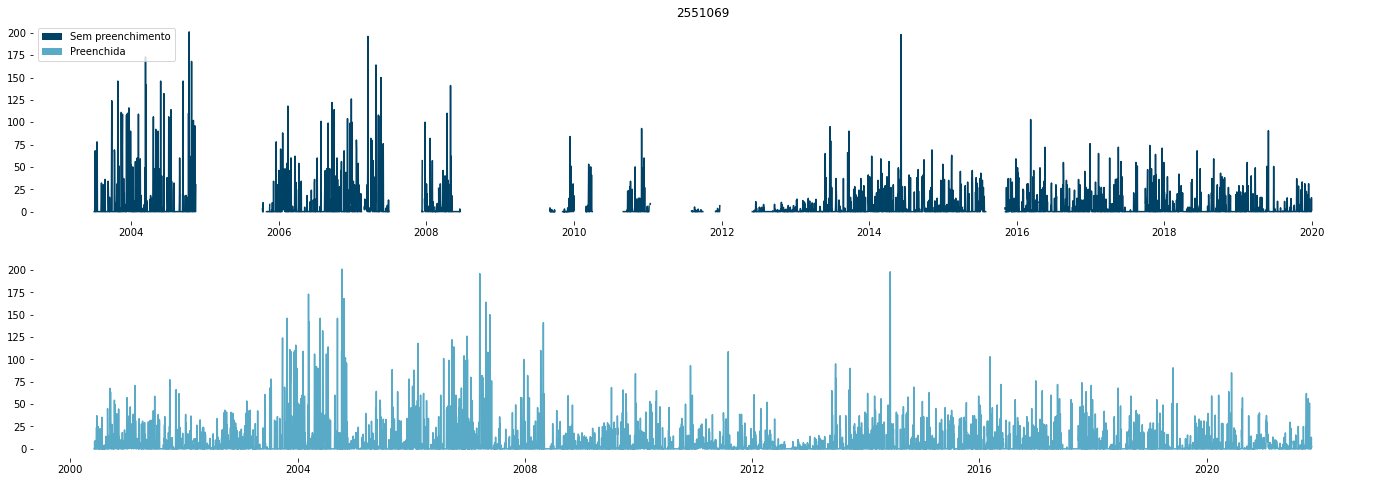

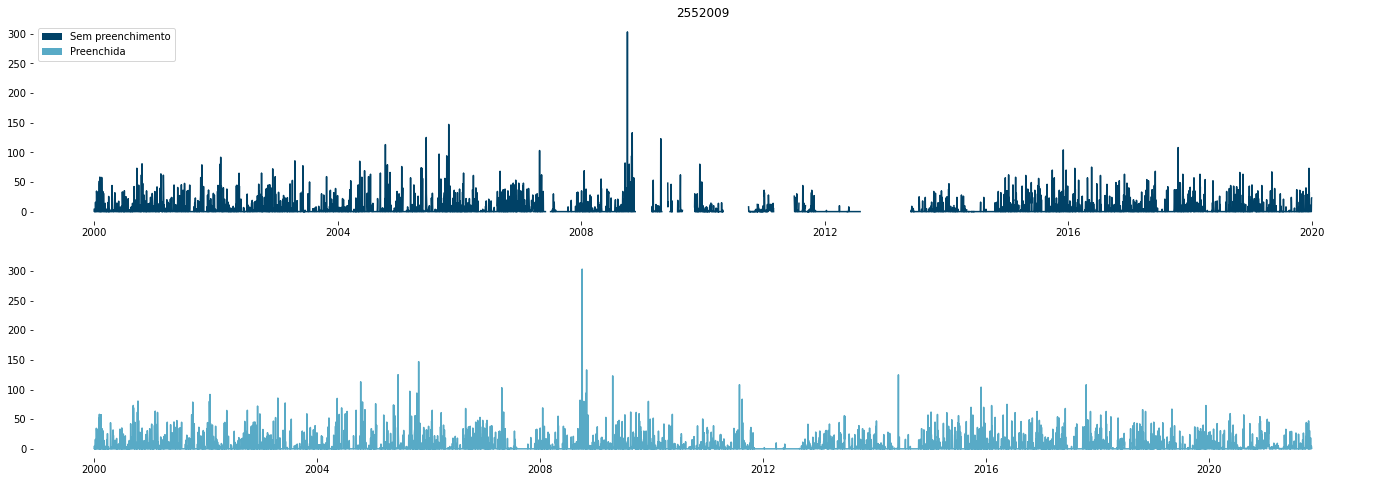

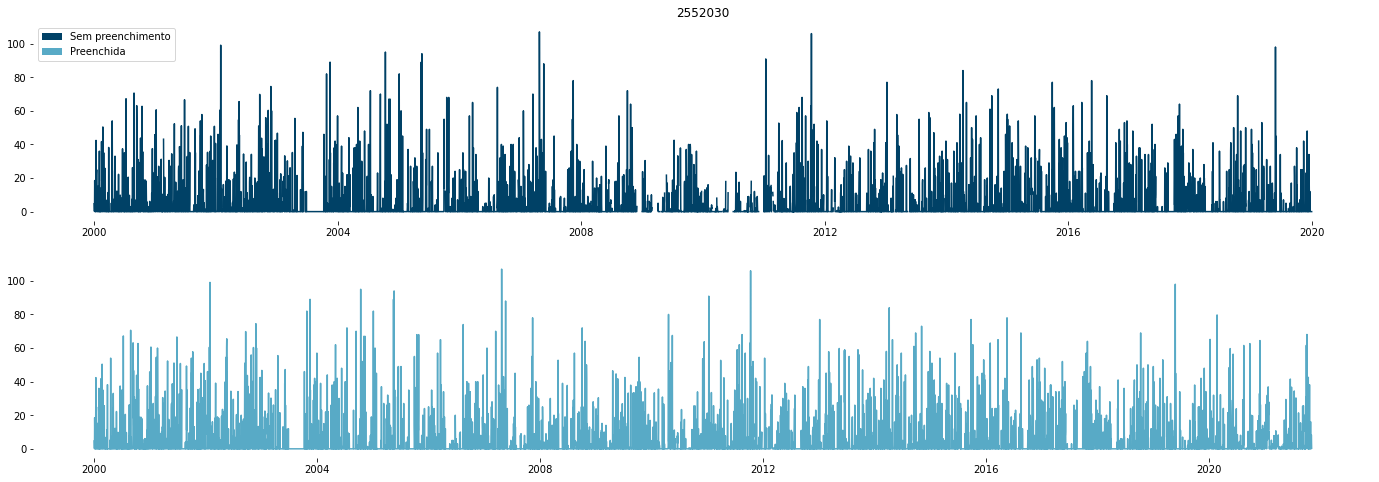

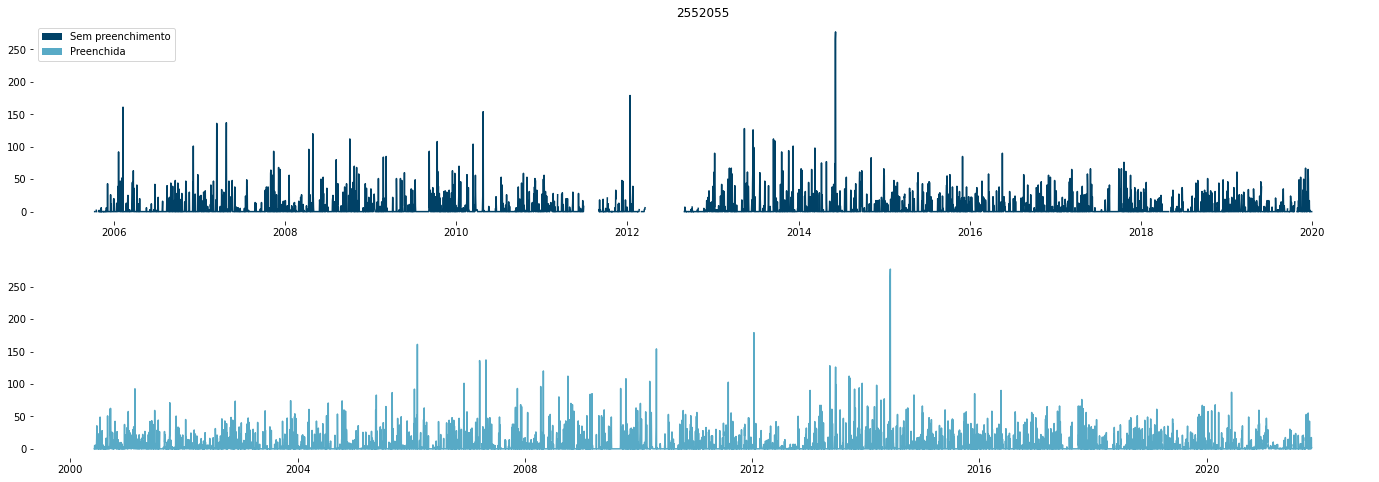

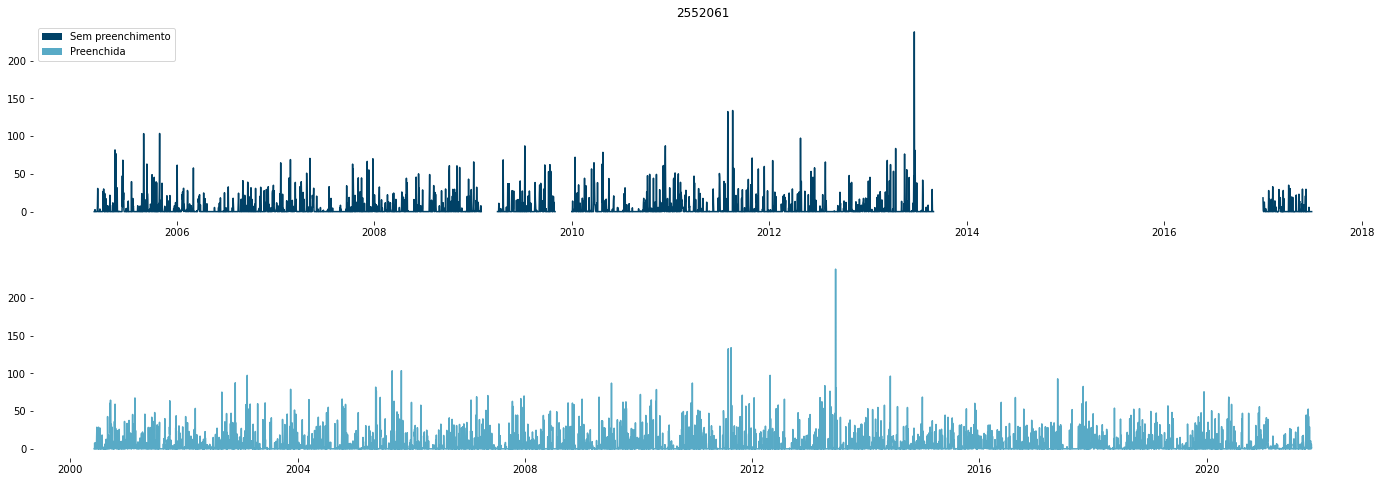

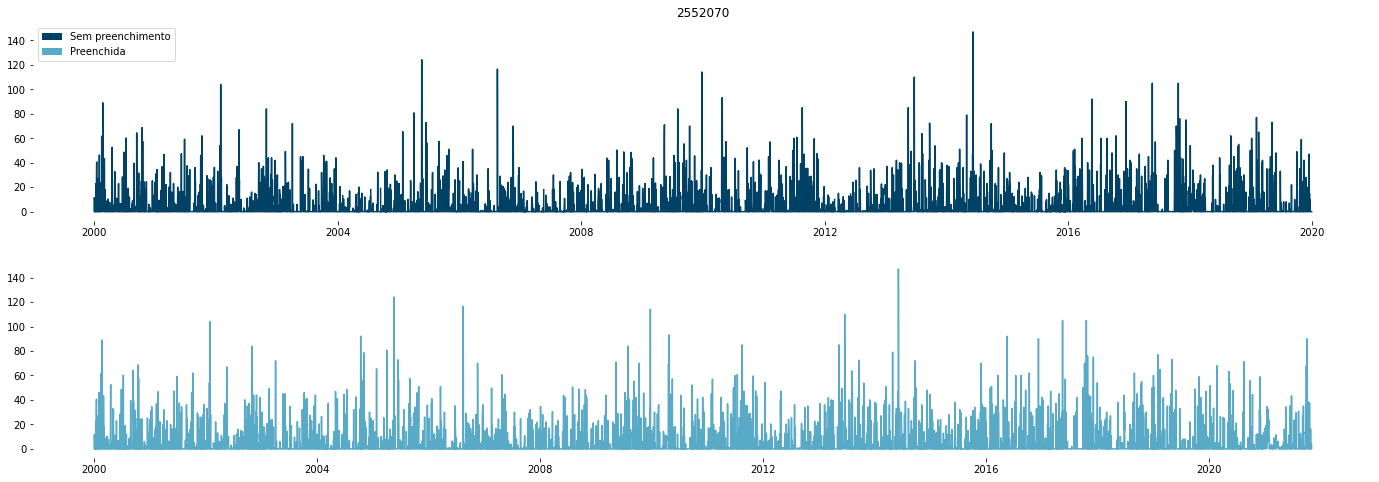

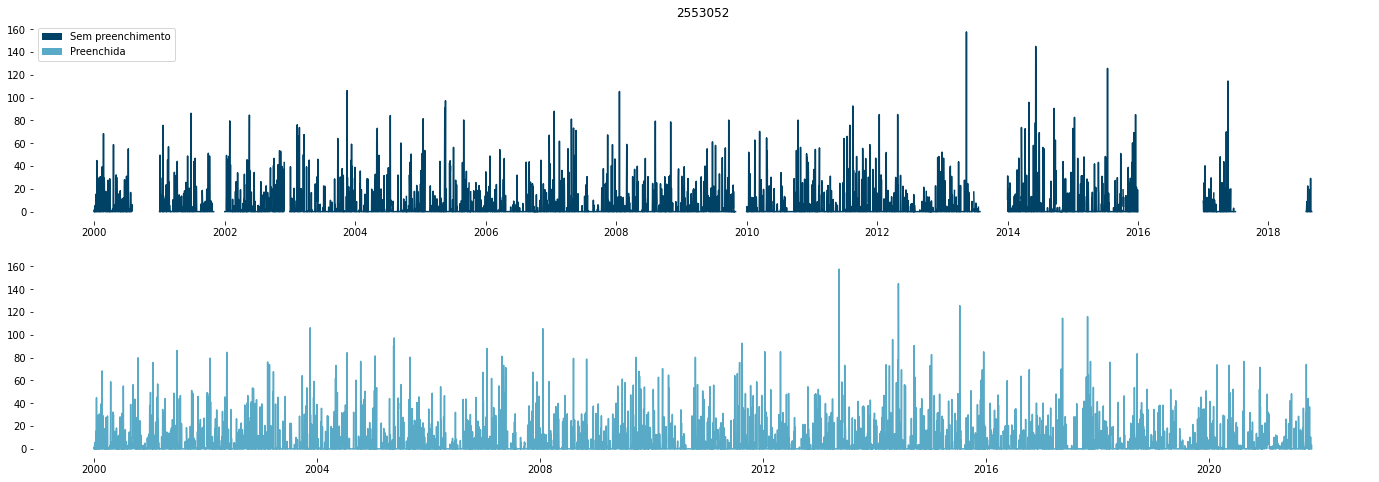

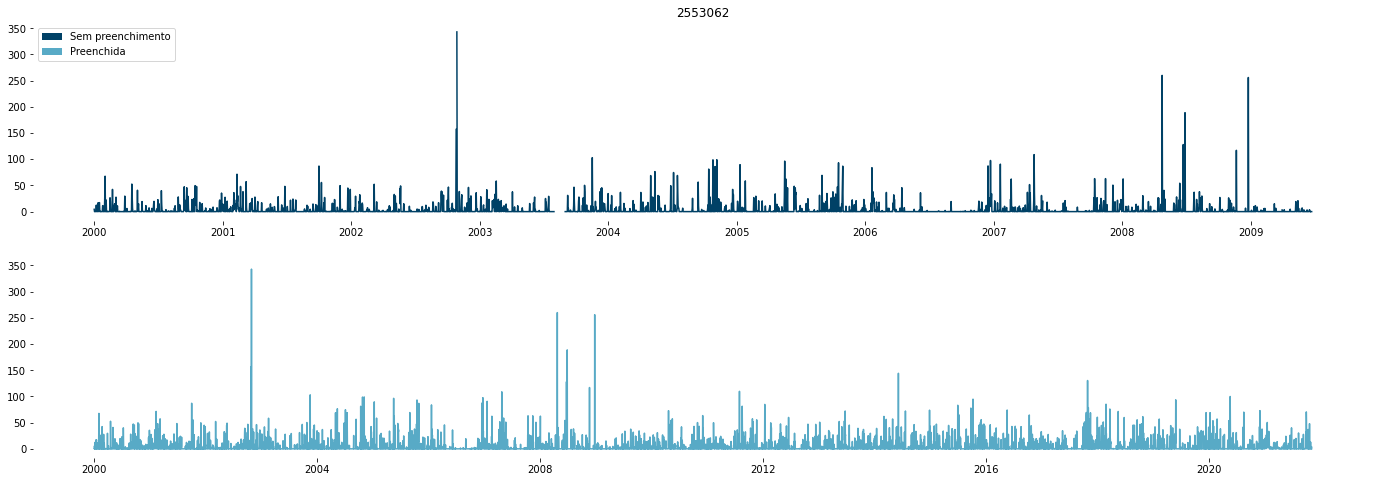

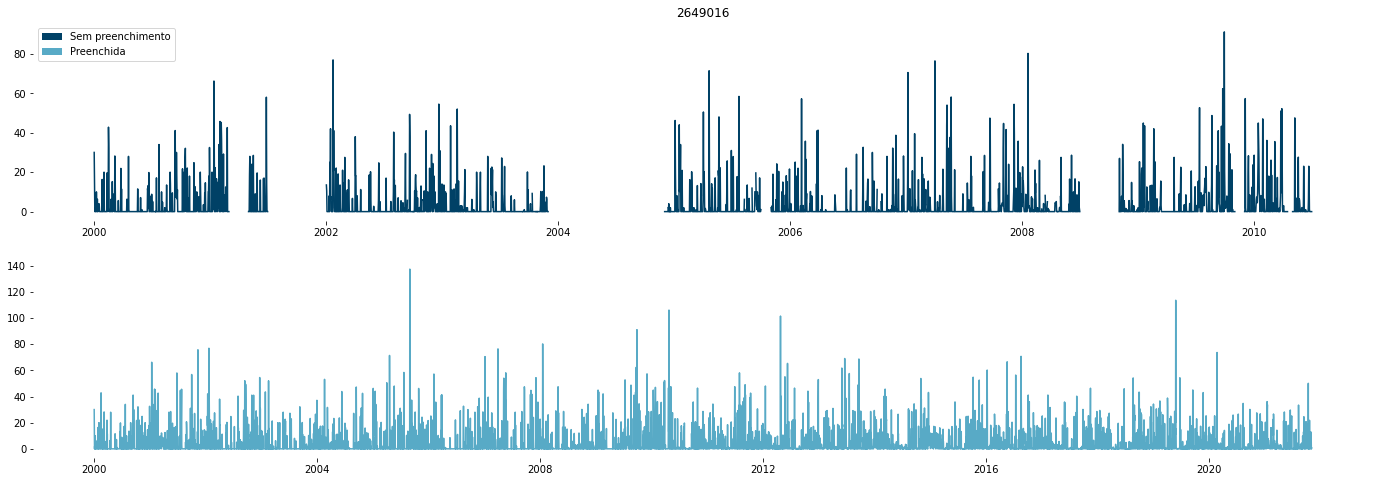

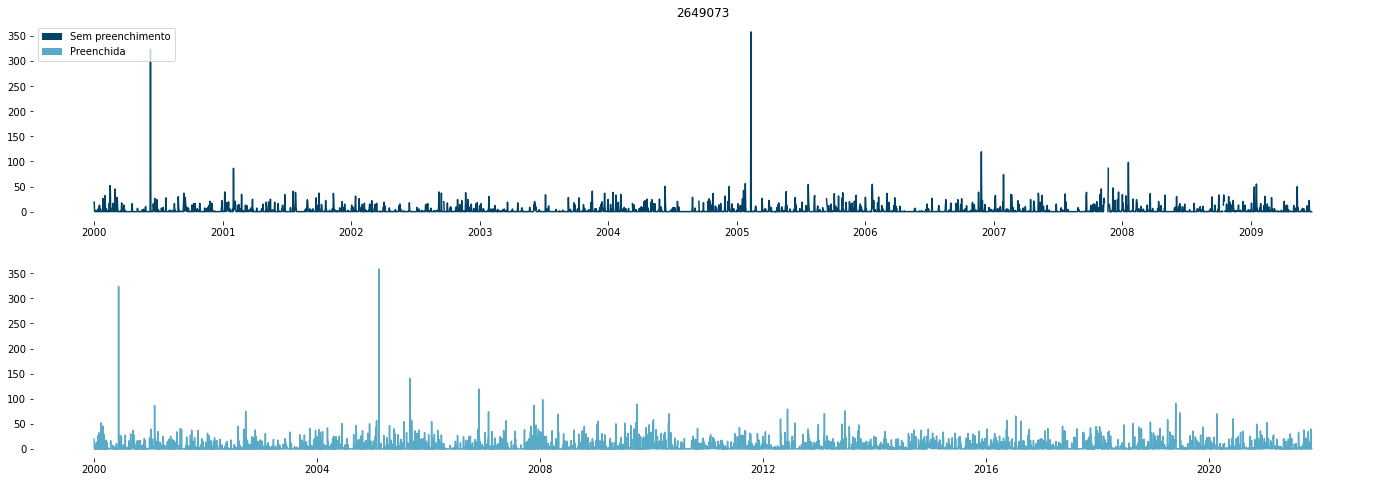

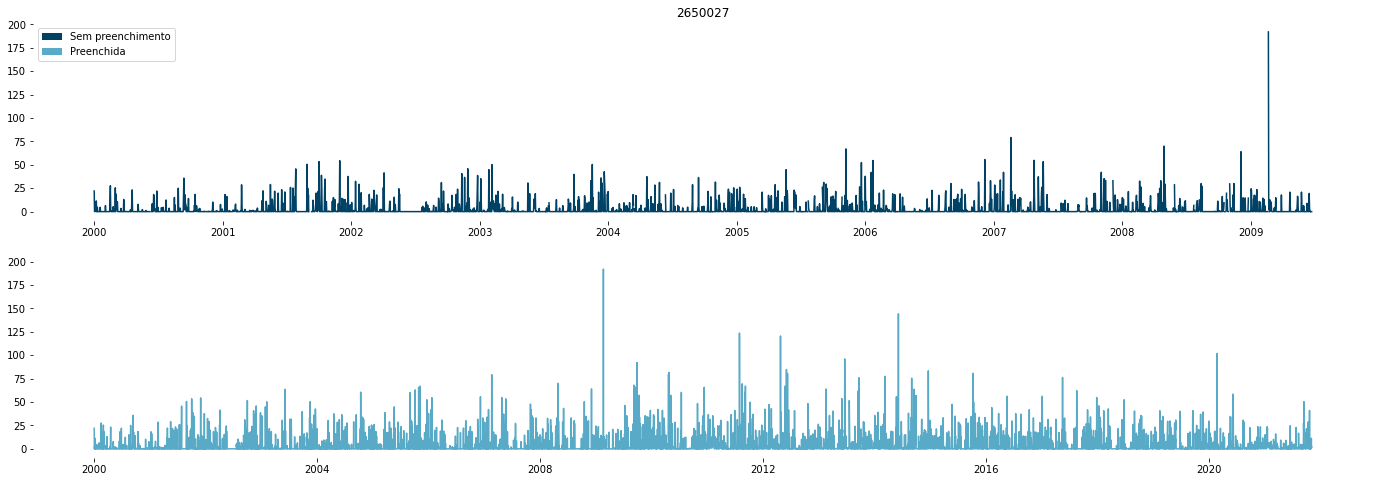

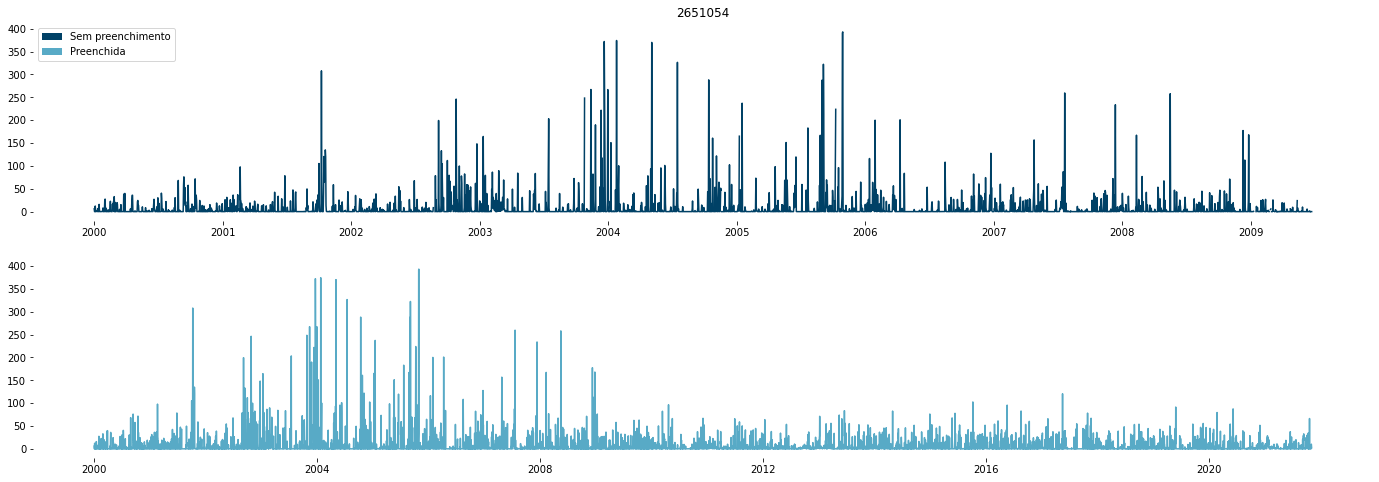

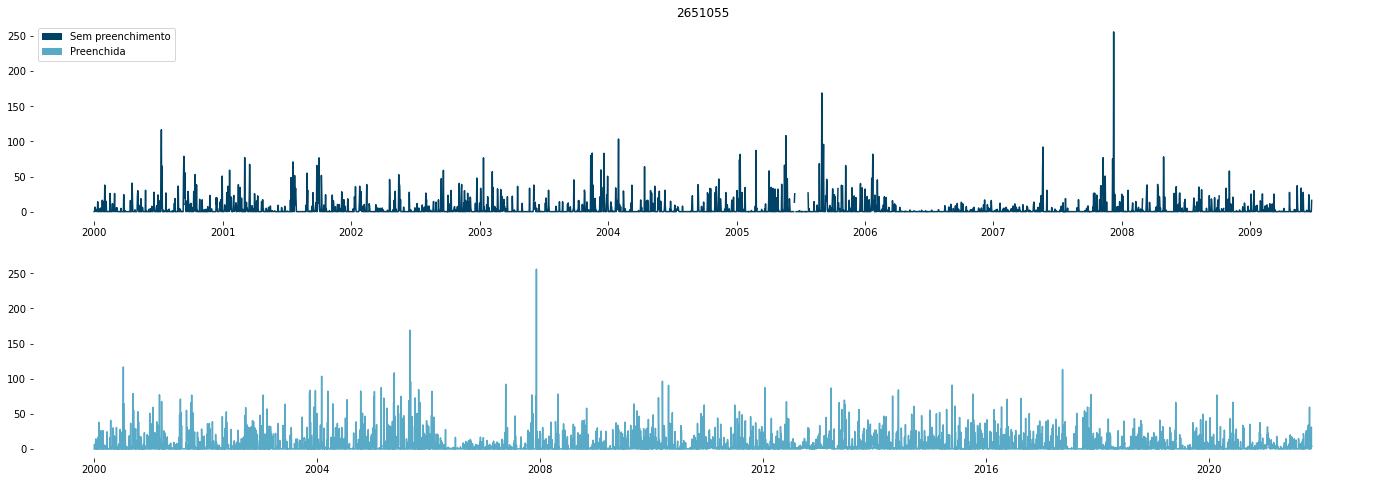

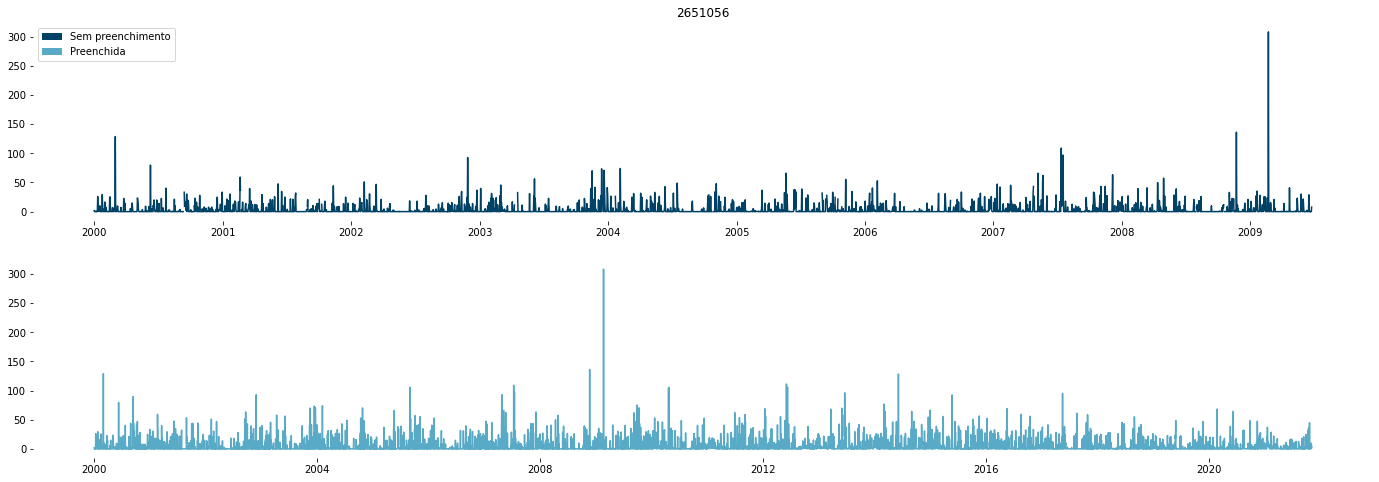

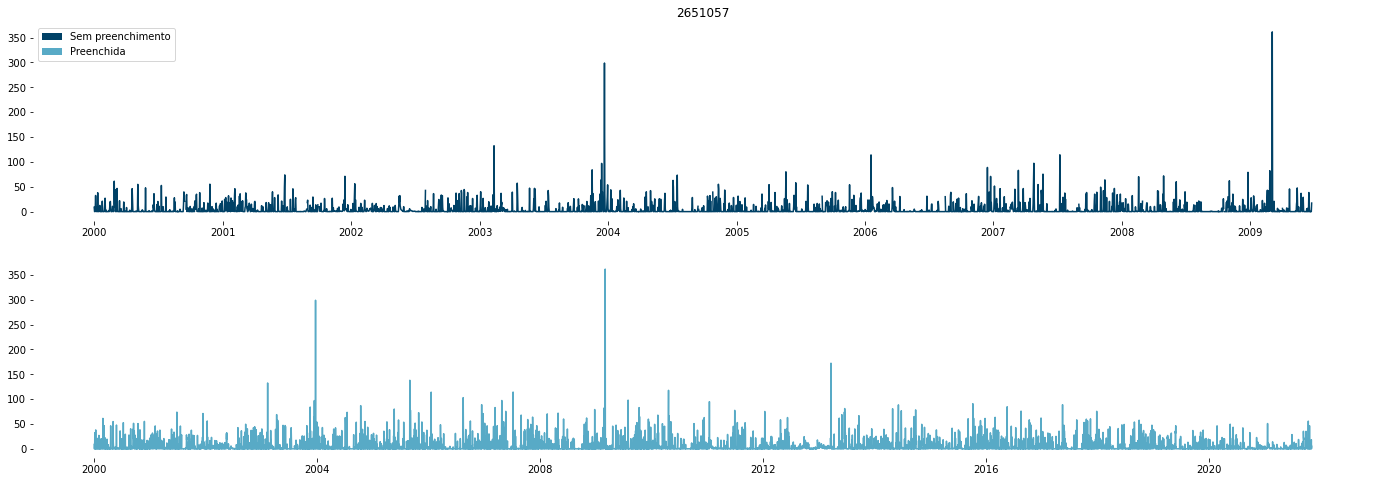

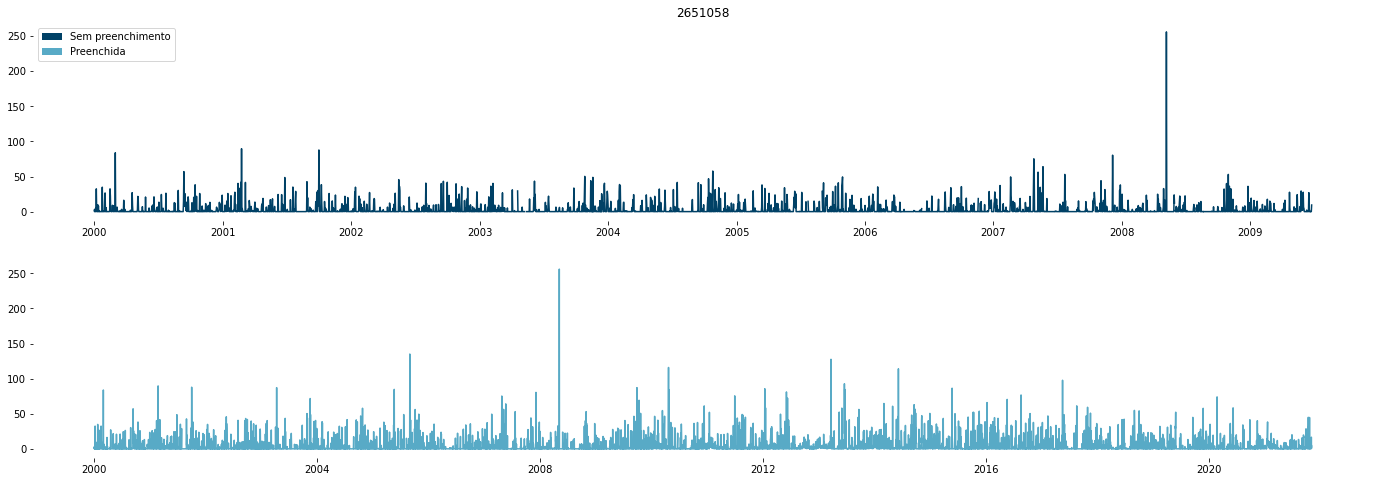

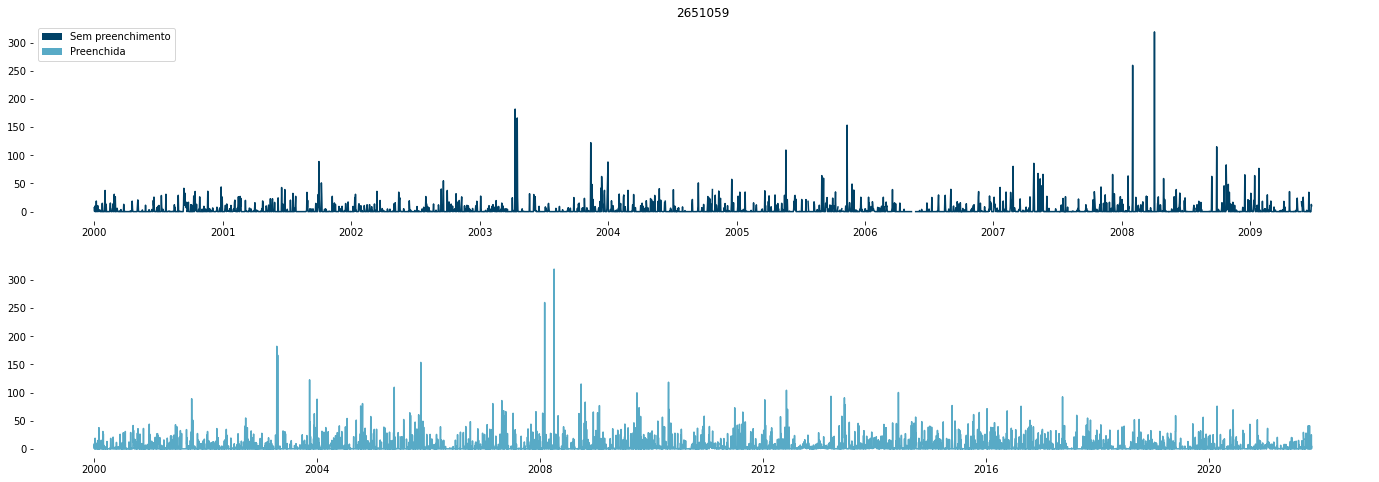

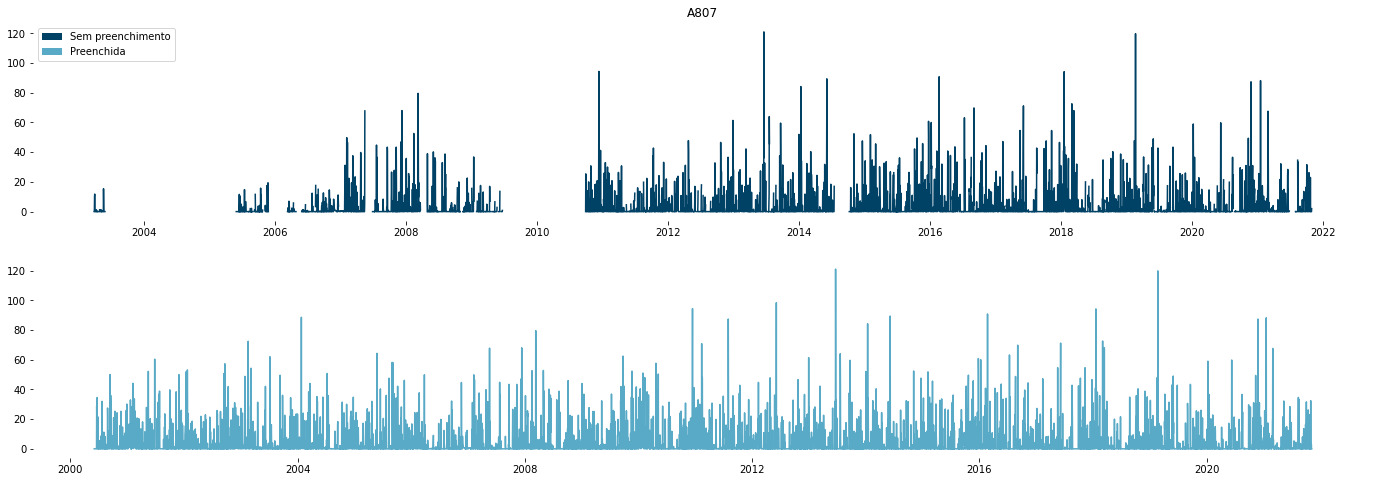

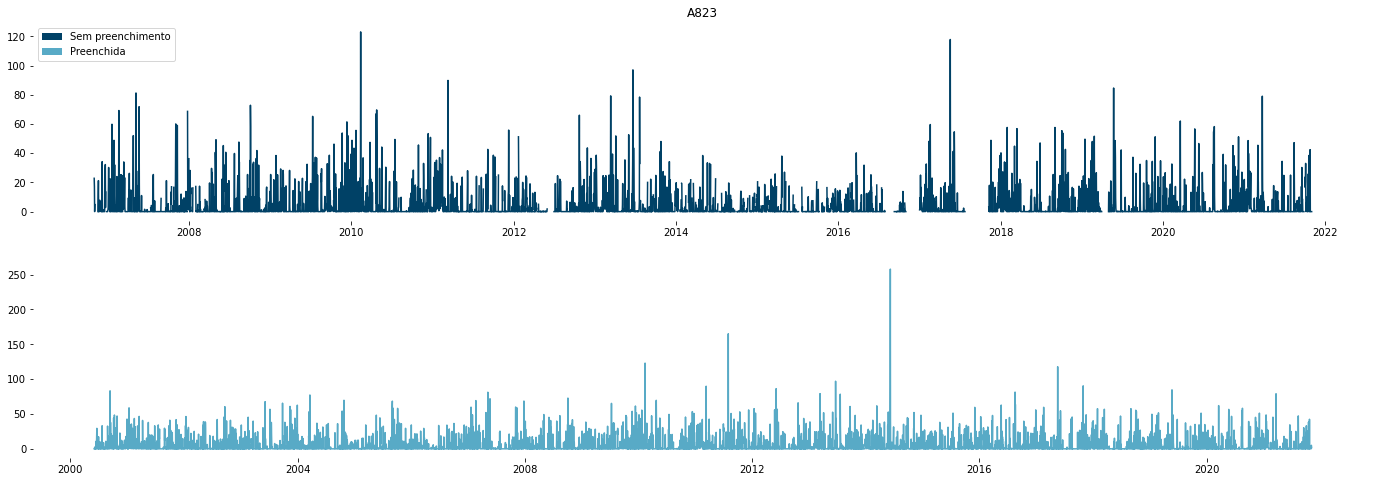

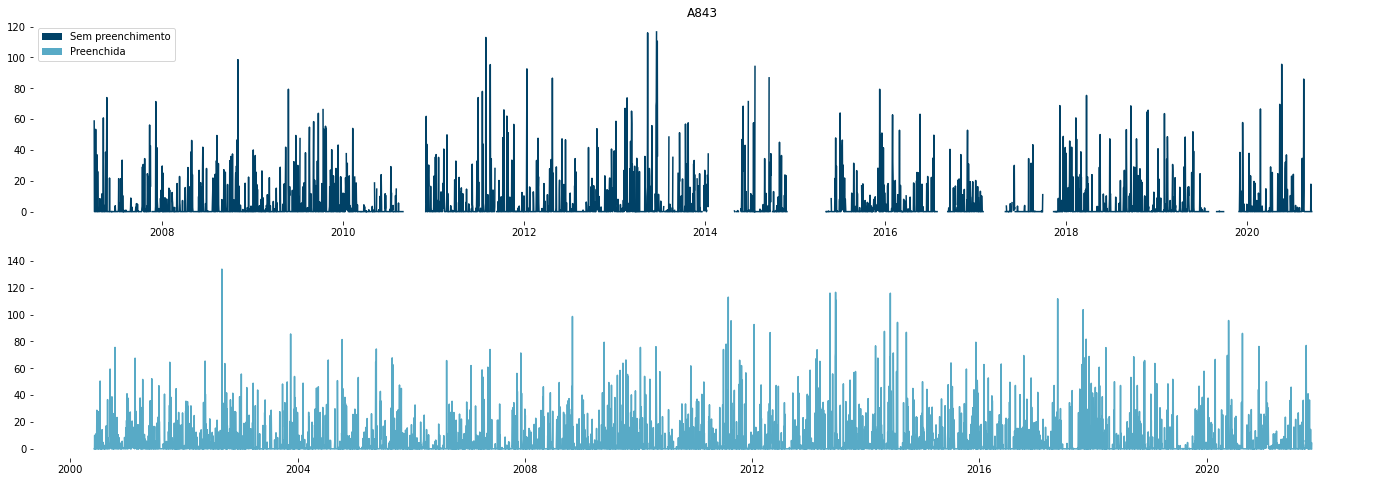

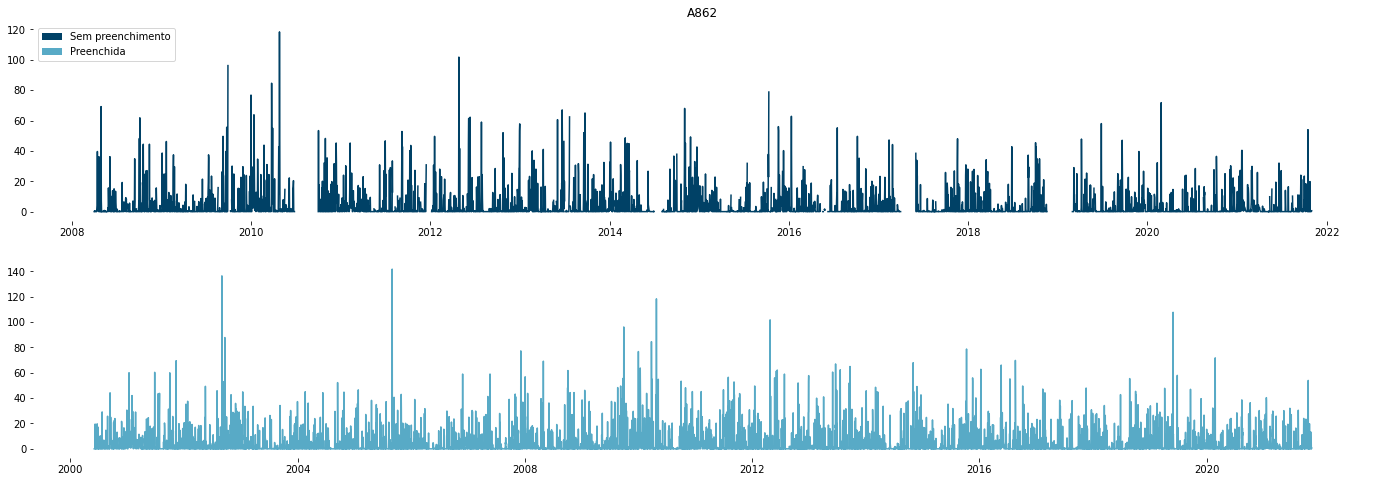

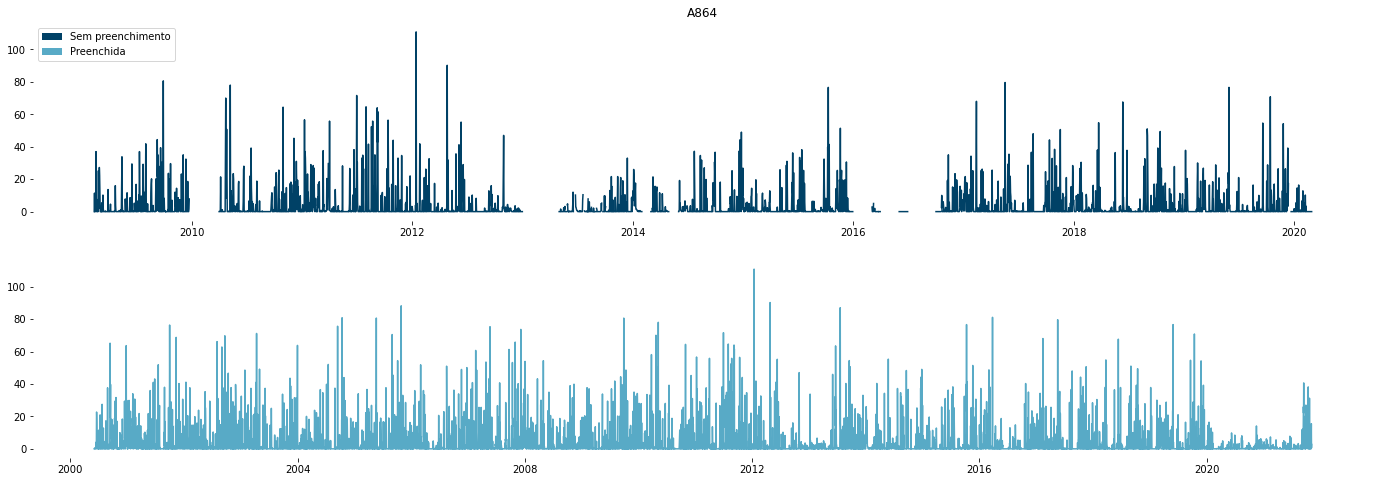

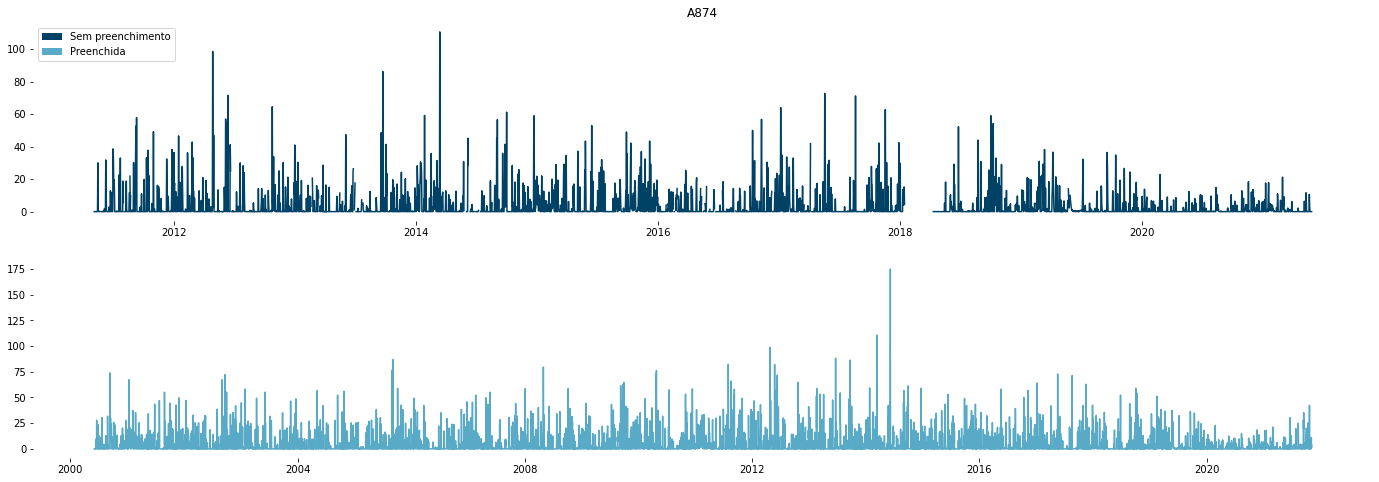

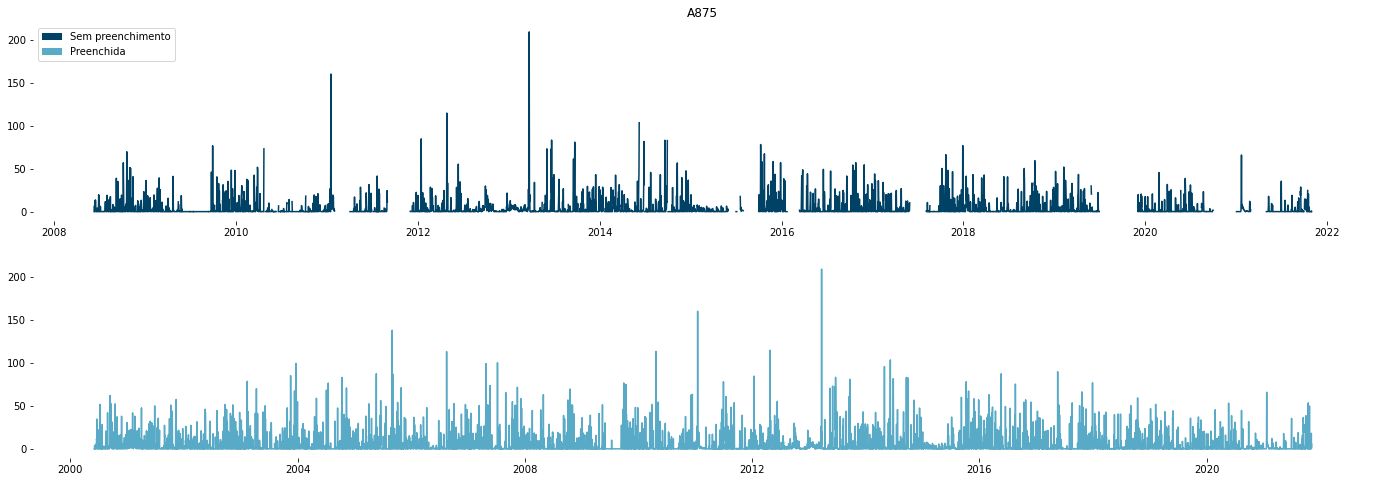

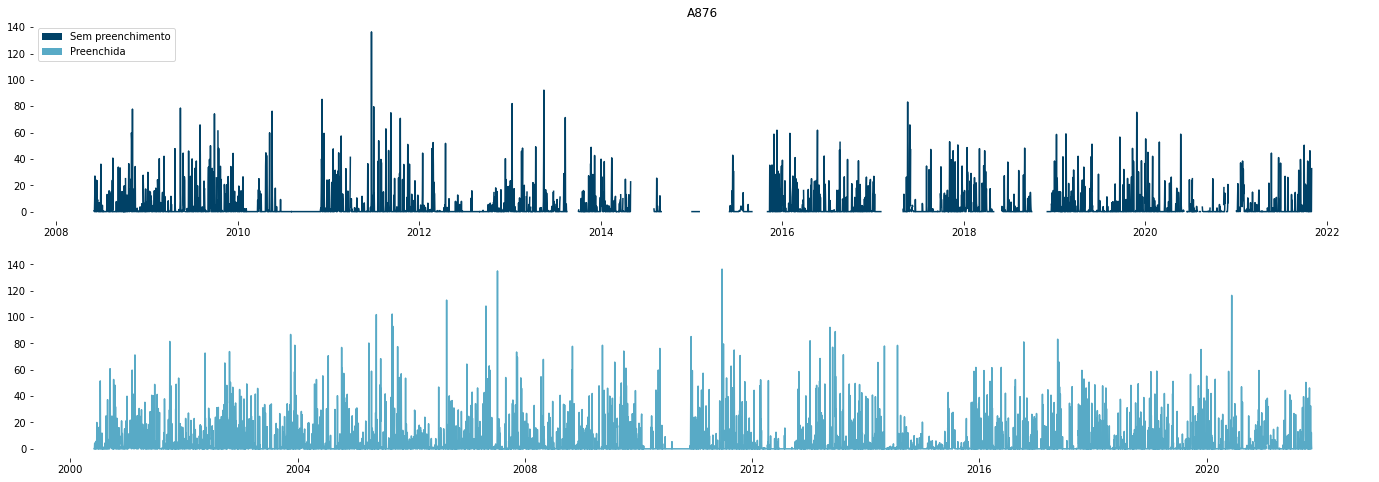

In [13]:
for serie_com_merge in series_com_merge:
    df = pd.read_csv(serie_com_merge, index_col=0)
    
    df.index = pd.to_datetime(df.index)

    codigo_posto = serie_com_merge.stem
    serie_posto = df[codigo_posto]
    serie_satelite = df['merge']

    serie_preenchida = serie_posto.combine_first(serie_satelite)
    serie_preenchida.to_csv(config.dir_final.joinpath(f"{codigo_posto}.csv"))

    fig, ax = plt.subplots(nrows=2, figsize=(24, 8))

    ax[0].plot(serie_posto, color="#004166")
    ax[1].plot(serie_preenchida, color="#58AAC6",)

    patches_legenda = [
        Patch(facecolor="#004166", label="Sem preenchimento",),
        Patch(facecolor="#58AAC6", label="Preenchida",),
    ]
    
    ax[0].set_title(f"{codigo_posto}")

    for key, spine in ax[0].spines.items():
        spine.set_visible(False)
    
    for key, spine in ax[1].spines.items():
        spine.set_visible(False)
    
    ax[0].legend(handles=patches_legenda, loc="upper left")